> **DO NOT RUN ALL OR IMAGE FOR PART 2 WILL NOT SHOW** 

In [249]:
%matplotlib inline
%load_ext tensorboard
import matplotlib.pylab as plt
import numpy as np
import random
import keras
import datetime
from scipy.interpolate import interp1d
import tensorflow as tf
import matplotlib.pylab as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import mnist


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Assignment 1

**Handin in Peergrade**: *Monday*, October 14, 2019, 23:59<br>
**Peergrading deadline**: *Friday*, October 18, 2019, 23:59<br>
**Peergrading feedback deadline**: *Sunday*, October 20, 2019, 23:59

[**Feedback**](http://ulfaslak.com/vent)

## Problems

### Week 1

In [13]:
# Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

def step(z, threshold=0.5):
    if z > threshold:
        return 1
    return 0

# Feed forward neural network class
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        
        self.num_layers = len(sizes)
        self.sizes = sizes
        
        # Q: Print these out, explain their contents. You can instantiate a network by
        # doing `net = Network([2, 3, 1])`, and then printing `net.biases`.
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        
        # Q: What is `a`? How many iterations will this loop run? For a `sizes=[2, 3, 1]`
        # network, what is the shape of `a` at each iteration?
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None, silent=False):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        
        # Ulf: For now we just treat this function as a black box.
        
        n = len(training_data)
        if test_data:
            n_test = len(test_data)
        
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]
            
            # Q: And what does this step do?
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            
            if not silent:
                if test_data:
                    print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
                else:
                    print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        
        # Ulf: For now we just treat this function as a black box.

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        self.weights = [
            w - eta / len(mini_batch) * nw
            for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - eta / len(mini_batch) * nb
            for b, nb in zip(self.biases, nabla_b)
        ]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        
        # Ulf: For now we just treat this function as a black box.
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book. Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on. It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return nabla_b, nabla_w

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        if self.sizes[-1] == 1:
            test_results = [
                (step(self.feedforward(x)), y)
                for x, y in test_data
            ]
        else:
            test_results = [
                (np.argmax(self.feedforward(x)), y)
                for x, y in test_data
            ]
        return sum(int(y_pred == y) for (y_pred, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return output_activations - y

In [14]:
def generate_X_linear(N=200):
    X = np.vstack([
        np.random.normal([-2, -2], 1, size=(int(N/2), 2)),
        np.random.normal([2, 2], 1, size=(int(N/2), 2))
    ])

    y = np.array([0] * int(N/2) + [1] * int(N/2)).reshape(-1, 1)
    
    return X, y

def generate_X_nonlinear(N=200, R=5):
    X_inner = np.random.normal([0, 0], 1, size=(int(N/2), 2))

    X_outer = np.array([
        [R*np.cos(theta), R*np.sin(theta)]
        for theta in np.linspace(0, 2 * np.pi, int(N/2))
    ]) + np.random.randn(int(N/2), 2)

    X = np.vstack([X_inner, X_outer])
    y = np.array([0] * int(N/2) + [1] * int(N/2)).reshape(-1, 1)
    
    return X, y

In [15]:
def prepare_data(X, y):
    """Format the dataset X and y so it fits with Nielsen's code."""
    return [
        (X[i].reshape(-1, 1), y[i].reshape(-1, 1))  # our tuple (x, y)
        for i in range(len(y))
    ]

In [23]:
class cmap_in_range:
    """Create map to range of colors inside given domain.

    Example
    -------
    >>> cmap = cmap_in_range([0, 1])
    >>> cmap(0.1)
    (0.30392156862745101, 0.30315267411304353, 0.98816547208125938, 1.0)
    """
    def __init__(self, cmap_domain, cmap_range=[0, 1], cmap_style='rainbow'):
        self.cmap_domain = cmap_domain
        self.cmap_range = cmap_range
        self.m = interp1d(cmap_domain, cmap_range)
        self.cmap = plt.get_cmap(cmap_style)
        
    def __call__(self, value):
        if not self.cmap_domain[0] <= value <= self.cmap_domain[1]:
            raise Exception("Value must be inside cmap_domain.")
        return self.cmap(self.m(value))

> **Ex. 1.2.2**: Create a neural network with `sizes=[2, 1]`. This is actually just our most basic Perceptron model with two inputs and a single output. Generate 1e5 training datapoints and 1e4 testing datapoints using the `generate_X_linear` function, and fit the neural network to this data. Once you've fitted the network, make two plots of your test datapoints, one where points are colored by predictions and another where points are colored by their true labels. Can you say something about the points that are being mislabeled?
>
>*Hint*: You'll probably find some of Nielsen's examples from [Chapter 1](http://neuralnetworksanddeeplearning.com/chap1.html) in his book useful. Also, note that predictions are values between 0 and 1, not hard 0s and 1s, due to the sigmoid activation function. You can deal with this however you like when you color the points by prediction.

In [205]:
#SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None, silent=False):

#declare neural net
lNet = Network([2,1])

#generate data
l_x_train, l_y_train = generate_X_linear(1e5)
l_x_test, l_y_test = generate_X_linear(1e4)

#format
data1_train = prepare_data(l_x_train, l_y_train)
data1_test = prepare_data(l_x_test, l_y_test)

#train
lNet.SGD(data1_train, 3, 100, 80, data1_test)

Epoch 0: 9973 / 10000
Epoch 1: 9973 / 10000
Epoch 2: 9973 / 10000


In [206]:
result1 = lNet.evaluate(data1_test)
print("Network has ",result1/len(data1_test)," accuracy on test set")

Network has  0.9973  accuracy on test set


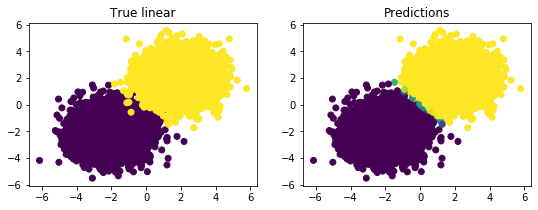

In [210]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.title("True linear", fontsize=12)
plt.scatter(l_x_test[:, 0], l_x_test[:, 1], c=list(l_y_test.reshape(-1)))


plt.subplot(1, 2, 2)
plt.title("Predictions", fontsize=12)

color = np.array([lNet.feedforward(X[0]) for X in data1_test]).flatten()
    
plt.scatter(l_x_test[:, 0], l_x_test[:, 1], c=color)

plt.show()

> The points that are mislabeled are outliers that cross over the boundary of the 2 classes

> **Ex. 1.2.3**: Now we want to do the same thing as in Ex. 1.2.2, but with the data generated with the `generate_X_nonlinear` function.
>
>*Hint*: Think back to the slides to figure out what `sizes` should be.

In [221]:
#declare neural net
nl_Net = Network([2,6,1]) #cant converge with 2,3,1 network quickly

#generate data
nl_x_train, nl_y_train = generate_X_nonlinear(1e5)
nl_x_test, nl_y_test = generate_X_nonlinear(1e4)

#format
data2_train = prepare_data(nl_x_train, nl_y_train)
data2_test = prepare_data(nl_x_test, nl_y_test)

#train
nl_Net.SGD(data2_train , 50, 100, 1, data2_test)

Epoch 0: 9822 / 10000
Epoch 1: 9830 / 10000
Epoch 2: 9829 / 10000
Epoch 3: 9836 / 10000
Epoch 4: 9842 / 10000
Epoch 5: 9840 / 10000
Epoch 6: 9836 / 10000
Epoch 7: 9846 / 10000
Epoch 8: 9843 / 10000
Epoch 9: 9845 / 10000
Epoch 10: 9847 / 10000
Epoch 11: 9844 / 10000
Epoch 12: 9849 / 10000
Epoch 13: 9844 / 10000
Epoch 14: 9844 / 10000
Epoch 15: 9846 / 10000
Epoch 16: 9847 / 10000
Epoch 17: 9849 / 10000
Epoch 18: 9849 / 10000
Epoch 19: 9844 / 10000
Epoch 20: 9846 / 10000
Epoch 21: 9844 / 10000
Epoch 22: 9845 / 10000
Epoch 23: 9846 / 10000
Epoch 24: 9847 / 10000
Epoch 25: 9847 / 10000
Epoch 26: 9848 / 10000
Epoch 27: 9848 / 10000
Epoch 28: 9846 / 10000
Epoch 29: 9848 / 10000
Epoch 30: 9846 / 10000
Epoch 31: 9843 / 10000
Epoch 32: 9844 / 10000
Epoch 33: 9846 / 10000
Epoch 34: 9845 / 10000
Epoch 35: 9844 / 10000
Epoch 36: 9846 / 10000
Epoch 37: 9847 / 10000
Epoch 38: 9847 / 10000
Epoch 39: 9846 / 10000
Epoch 40: 9848 / 10000
Epoch 41: 9845 / 10000
Epoch 42: 9845 / 10000
Epoch 43: 9847 / 1000

In [222]:
result2 = nl_Net.evaluate(data2_test)
print("Network has ",result2/len(data2_test)," accuracy on test set")

Network has  0.9846  accuracy on test set


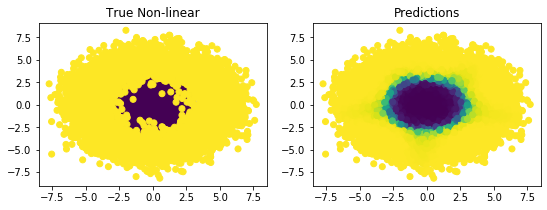

In [269]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.title("True Non-linear", fontsize=12)
plt.scatter(nl_x_test[:, 0], nl_x_test[:, 1], c=list(nl_y_test.reshape(-1)))

plt.subplot(1, 2, 2)

plt.title("Predictions", fontsize=12)

color = np.array([nl_Net.feedforward(X[0]) for X in data2_test]).flatten()
    
plt.scatter(nl_x_test[:, 0], nl_x_test[:, 1], c=color)

plt.show()

> The points that are mislabeled are yellow points crossing into the middle boundary and purple points that branch out to far from the center

### Week 2

<img src="https://raw.githubusercontent.com/abjer/tsds/master/material_exercises/week_3/2_3_1_net.png" alt="drawing" width="500"/>

> **Ex. 2.2.1**: The network above has a defined input and weights. If the true label for the datapoint `[4, 2]` is 1, what is the cost?
>
> A: The cost is 0.081796

> **Ex. 2.2.2**: Knowing about backpropagation, we actually have everything we need to compute the gradients of the weights by hand. So go ahead and do that. Report your answer either as a diagram that includes the gradients (you can draw on my figure somehow and insert the resulting image), or just by writing what the gradient of each weight is.
>
> *Hint: When computing gradients with backprop, it can be a bit easier to think of the network as a computational graph. My computational graph looks like [this](https://github.com/abjer/tsds/blob/master/material_exercises/week_3/2_3_1_net_compgraph.png?raw=true).*

<img src="https://raw.githubusercontent.com/derpnallday/neural_net_assignments/master/assignments/comp_graph_fwd.png?token=AFLMFZTAHDWZLFTLR5UCPSK5VW2EI" />

### Week 3

> **Ex. 3.1.3** Solve exercises 1.2.2 and 1.2.3 from week 1, but solve them using Keras.
> Comment on differences in speed (and outcome if you observe any).
You can for example use Tensorboard to inspect the training performance throught the training epochs.

In [218]:
#Linear data
model = Sequential()

#building layers
model.add(Dense(units=1, activation='sigmoid', input_dim = 2))
model.summary()

#optimizer
sgd = tf.optimizers.SGD(learning_rate=1, momentum=0.0, nesterov=False)

model.compile(loss='mse',
              optimizer=sgd,
              metrics=['accuracy','mse'])

log_dir="./logs/ex2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [219]:
#train
hist = model.fit(l_x_train, l_y_train, epochs=5, batch_size=100, callbacks=[tensorboard_callback])

Epoch 1/5
100000/100000 [==============================] - 1s 8us/step - loss: 0.0030 - accuracy: 0.9977 - mse: 0.0030
Epoch 2/5
100000/100000 [==============================] - 1s 7us/step - loss: 0.0020 - accuracy: 0.9977 - mse: 0.0020
Epoch 3/5
100000/100000 [==============================] - 1s 7us/step - loss: 0.0019 - accuracy: 0.9978 - mse: 0.0019
Epoch 4/5
100000/100000 [==============================] - 1s 7us/step - loss: 0.0019 - accuracy: 0.9977 - mse: 0.0019
Epoch 5/5
100000/100000 [==============================] - 1s 7us/step - loss: 0.0018 - accuracy: 0.9977 - mse: 0.0018


Accuracy should be around 99%

In [224]:
from keras import regularizers

#non-Linear data
nl_model = Sequential()

#building layers
nl_model.add(Dense(units=2, activation='sigmoid', input_dim = 2))
nl_model.add(Dense(units=6, activation='sigmoid'))
nl_model.add(Dense(units=1, activation='sigmoid'))
nl_model.summary()


sgd = tf.optimizers.SGD(learning_rate=1, momentum=0.0, nesterov=False)

nl_model.compile(loss='mse',
              optimizer=sgd,
              metrics=['accuracy','mse'])

log_dir="./logs/ex3/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 18        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [227]:
#train
hist = nl_model.fit(nl_x_train, nl_y_train, epochs=50, batch_size=100, callbacks=[tensorboard_callback])

Epoch 1/50
100000/100000 [==============================] - 1s 8us/step - loss: 0.1740 - accuracy: 0.7455 - mse: 0.1740
Epoch 2/50
100000/100000 [==============================] - 1s 8us/step - loss: 0.1153 - accuracy: 0.8490 - mse: 0.1153
Epoch 3/50
100000/100000 [==============================] - 1s 8us/step - loss: 0.1137 - accuracy: 0.8520 - mse: 0.1137
Epoch 4/50
100000/100000 [==============================] - 1s 8us/step - loss: 0.1126 - accuracy: 0.8561 - mse: 0.1126
Epoch 5/50
100000/100000 [==============================] - 1s 8us/step - loss: 0.1104 - accuracy: 0.8602 - mse: 0.1104
Epoch 6/50
100000/100000 [==============================] - 1s 8us/step - loss: 0.1090 - accuracy: 0.8627 - mse: 0.1090
Epoch 7/50
100000/100000 [==============================] - 1s 8us/step - loss: 0.1072 - accuracy: 0.8655 - mse: 0.1072
Epoch 8/50
100000/100000 [==============================] - 1s 8us/step - loss: 0.1060 - accuracy: 0.8665 - mse: 0.1060
Epoch 9/50
100000/100000 [==============

Accuracy should be around 98%

> **Ex. 3.2.1** To understand overfitting, we overfit some data! Let's fit a neural network to data that has no inherent patterns: *noise*.

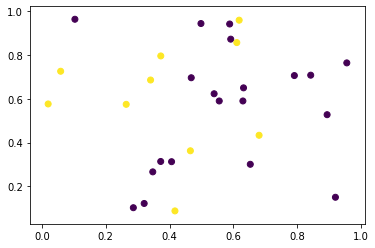

In [297]:
# Generate some data-points
x_ov = np.random.random(size=(30, 2))

# And some random outcomes
y_ov = np.random.randint(0, 2, size=(30, ))

# Plot it
plt.scatter(x_ov[:, 0], x_ov[:, 1], c=y_ov)
plt.show()

> Now, create a network that attains a an accuracy score over 80% in predicting which points are class 0 and which are class 1.
>
> *Hint*: The bigger the network, the bigger the overfitting.

In [298]:
ov_model = Sequential()

#building layers
ov_model.add(Dense(units=60, activation='relu', input_dim = 2))
ov_model.add(Dense(units=1, activation='sigmoid'))

ov_model.summary()

sgd = tf.optimizers.SGD(learning_rate=1, momentum=0.0, nesterov=False)

ov_model.compile(loss='mse',
              optimizer= sgd,
              metrics=['accuracy','mse'])

log_dir="./logs/ex4/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 60)                180       
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 61        
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


In [299]:
#train
ov_hist = ov_model.fit(x_ov, y_ov, epochs=10000, batch_size=30, callbacks=[tensorboard_callback])

#have to overtrain this, just wait for loss to continue going down (DO NOT RUN IT TAKE 15 MINUTES)

Epoch 1/10000
30/30 [==============================] - 0s 2ms/step - loss: 0.2493 - accuracy: 0.5667 - mse: 0.2493
Epoch 2/10000
30/30 [==============================] - 0s 284us/step - loss: 0.2326 - accuracy: 0.6667 - mse: 0.2326
Epoch 3/10000
30/30 [==============================] - 0s 50us/step - loss: 0.2252 - accuracy: 0.6667 - mse: 0.2252
Epoch 4/10000
30/30 [==============================] - 0s 68us/step - loss: 0.2211 - accuracy: 0.6667 - mse: 0.2211
Epoch 5/10000
30/30 [==============================] - 0s 45us/step - loss: 0.2189 - accuracy: 0.6667 - mse: 0.2189
Epoch 6/10000
30/30 [==============================] - 0s 50us/step - loss: 0.2173 - accuracy: 0.6667 - mse: 0.2173
Epoch 7/10000
30/30 [==============================] - 0s 60us/step - loss: 0.2160 - accuracy: 0.6667 - mse: 0.2160
Epoch 8/10000
30/30 [==============================] - 0s 54us/step - loss: 0.2149 - accuracy: 0.6667 - mse: 0.2149
Epoch 9/10000
30/30 [==============================] - 0s 43us/step - lo

Epoch 72/10000
30/30 [==============================] - 0s 41us/step - loss: 0.1905 - accuracy: 0.7000 - mse: 0.1905
Epoch 73/10000
30/30 [==============================] - 0s 38us/step - loss: 0.1904 - accuracy: 0.7000 - mse: 0.1904
Epoch 74/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1902 - accuracy: 0.7000 - mse: 0.1902
Epoch 75/10000
30/30 [==============================] - 0s 41us/step - loss: 0.1901 - accuracy: 0.7000 - mse: 0.1901
Epoch 76/10000
30/30 [==============================] - 0s 36us/step - loss: 0.1899 - accuracy: 0.7000 - mse: 0.1899
Epoch 77/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1898 - accuracy: 0.7000 - mse: 0.1898
Epoch 78/10000
30/30 [==============================] - 0s 104us/step - loss: 0.1897 - accuracy: 0.7000 - mse: 0.1897
Epoch 79/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1895 - accuracy: 0.7000 - mse: 0.1895
Epoch 80/10000
30/30 [==============================] - 0s 46us

Epoch 142/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1849 - accuracy: 0.8000 - mse: 0.1849
Epoch 143/10000
30/30 [==============================] - 0s 57us/step - loss: 0.1848 - accuracy: 0.7667 - mse: 0.1848
Epoch 144/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1848 - accuracy: 0.8000 - mse: 0.1848
Epoch 145/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1848 - accuracy: 0.8000 - mse: 0.1848
Epoch 146/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1847 - accuracy: 0.8000 - mse: 0.1847
Epoch 147/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1847 - accuracy: 0.8000 - mse: 0.1847
Epoch 148/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1847 - accuracy: 0.8000 - mse: 0.1847
Epoch 149/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1846 - accuracy: 0.8000 - mse: 0.1846
Epoch 150/10000
30/30 [==============================] -

Epoch 212/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1831 - accuracy: 0.8000 - mse: 0.1831
Epoch 213/10000
30/30 [==============================] - 0s 46us/step - loss: 0.1831 - accuracy: 0.8000 - mse: 0.1831
Epoch 214/10000
30/30 [==============================] - 0s 102us/step - loss: 0.1831 - accuracy: 0.8000 - mse: 0.1831
Epoch 215/10000
30/30 [==============================] - 0s 69us/step - loss: 0.1831 - accuracy: 0.8000 - mse: 0.1831
Epoch 216/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1831 - accuracy: 0.8000 - mse: 0.1831
Epoch 217/10000
30/30 [==============================] - 0s 91us/step - loss: 0.1831 - accuracy: 0.8000 - mse: 0.1831
Epoch 218/10000
30/30 [==============================] - 0s 62us/step - loss: 0.1830 - accuracy: 0.8000 - mse: 0.1830
Epoch 219/10000
30/30 [==============================] - 0s 40us/step - loss: 0.1830 - accuracy: 0.8000 - mse: 0.1830
Epoch 220/10000
30/30 [==============================] 

Epoch 282/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1820 - accuracy: 0.8000 - mse: 0.1820
Epoch 283/10000
30/30 [==============================] - 0s 50us/step - loss: 0.1820 - accuracy: 0.8000 - mse: 0.1820
Epoch 284/10000
30/30 [==============================] - 0s 43us/step - loss: 0.1820 - accuracy: 0.8000 - mse: 0.1820
Epoch 285/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1819 - accuracy: 0.8000 - mse: 0.1819
Epoch 286/10000
30/30 [==============================] - 0s 52us/step - loss: 0.1819 - accuracy: 0.8000 - mse: 0.1819
Epoch 287/10000
30/30 [==============================] - 0s 41us/step - loss: 0.1819 - accuracy: 0.8000 - mse: 0.1819
Epoch 288/10000
30/30 [==============================] - 0s 38us/step - loss: 0.1819 - accuracy: 0.8000 - mse: 0.1819
Epoch 289/10000
30/30 [==============================] - 0s 52us/step - loss: 0.1819 - accuracy: 0.8000 - mse: 0.1819
Epoch 290/10000
30/30 [==============================] -

Epoch 352/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1810 - accuracy: 0.8000 - mse: 0.1810
Epoch 353/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1809 - accuracy: 0.8000 - mse: 0.1809
Epoch 354/10000
30/30 [==============================] - 0s 74us/step - loss: 0.1810 - accuracy: 0.8000 - mse: 0.1810
Epoch 355/10000
30/30 [==============================] - 0s 39us/step - loss: 0.1809 - accuracy: 0.8000 - mse: 0.1809
Epoch 356/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1809 - accuracy: 0.8000 - mse: 0.1809
Epoch 357/10000
30/30 [==============================] - 0s 90us/step - loss: 0.1809 - accuracy: 0.8000 - mse: 0.1809
Epoch 358/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1809 - accuracy: 0.8000 - mse: 0.1809
Epoch 359/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1809 - accuracy: 0.8000 - mse: 0.1809
Epoch 360/10000
30/30 [==============================] -

Epoch 422/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1799 - accuracy: 0.8000 - mse: 0.1799
Epoch 423/10000
30/30 [==============================] - 0s 66us/step - loss: 0.1799 - accuracy: 0.8000 - mse: 0.1799
Epoch 424/10000
30/30 [==============================] - 0s 68us/step - loss: 0.1799 - accuracy: 0.8000 - mse: 0.1799
Epoch 425/10000
30/30 [==============================] - 0s 40us/step - loss: 0.1799 - accuracy: 0.8000 - mse: 0.1799
Epoch 426/10000
30/30 [==============================] - 0s 41us/step - loss: 0.1799 - accuracy: 0.8000 - mse: 0.1799
Epoch 427/10000
30/30 [==============================] - 0s 36us/step - loss: 0.1799 - accuracy: 0.8000 - mse: 0.1799
Epoch 428/10000
30/30 [==============================] - 0s 41us/step - loss: 0.1799 - accuracy: 0.8000 - mse: 0.1799
Epoch 429/10000
30/30 [==============================] - 0s 40us/step - loss: 0.1798 - accuracy: 0.8000 - mse: 0.1798
Epoch 430/10000
30/30 [==============================] -

Epoch 492/10000
30/30 [==============================] - 0s 82us/step - loss: 0.1785 - accuracy: 0.8000 - mse: 0.1785
Epoch 493/10000
30/30 [==============================] - 0s 52us/step - loss: 0.1784 - accuracy: 0.8000 - mse: 0.1784
Epoch 494/10000
30/30 [==============================] - 0s 50us/step - loss: 0.1784 - accuracy: 0.8000 - mse: 0.1784
Epoch 495/10000
30/30 [==============================] - 0s 84us/step - loss: 0.1784 - accuracy: 0.8000 - mse: 0.1784
Epoch 496/10000
30/30 [==============================] - 0s 40us/step - loss: 0.1784 - accuracy: 0.8000 - mse: 0.1784
Epoch 497/10000
30/30 [==============================] - 0s 49us/step - loss: 0.1784 - accuracy: 0.8000 - mse: 0.1784
Epoch 498/10000
30/30 [==============================] - 0s 57us/step - loss: 0.1783 - accuracy: 0.8000 - mse: 0.1783
Epoch 499/10000
30/30 [==============================] - 0s 81us/step - loss: 0.1783 - accuracy: 0.8000 - mse: 0.1783
Epoch 500/10000
30/30 [==============================] -

Epoch 562/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1765 - accuracy: 0.8000 - mse: 0.1765
Epoch 563/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1764 - accuracy: 0.8000 - mse: 0.1764
Epoch 564/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1763 - accuracy: 0.8000 - mse: 0.1763
Epoch 565/10000
30/30 [==============================] - 0s 50us/step - loss: 0.1764 - accuracy: 0.8000 - mse: 0.1764
Epoch 566/10000
30/30 [==============================] - 0s 133us/step - loss: 0.1763 - accuracy: 0.8000 - mse: 0.1763
Epoch 567/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1763 - accuracy: 0.8000 - mse: 0.1763
Epoch 568/10000
30/30 [==============================] - 0s 52us/step - loss: 0.1763 - accuracy: 0.8000 - mse: 0.1763
Epoch 569/10000
30/30 [==============================] - 0s 67us/step - loss: 0.1762 - accuracy: 0.8000 - mse: 0.1762
Epoch 570/10000
30/30 [==============================] 

Epoch 632/10000
30/30 [==============================] - 0s 46us/step - loss: 0.1745 - accuracy: 0.8000 - mse: 0.1745
Epoch 633/10000
30/30 [==============================] - 0s 39us/step - loss: 0.1745 - accuracy: 0.8000 - mse: 0.1745
Epoch 634/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1745 - accuracy: 0.8000 - mse: 0.1745
Epoch 635/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1745 - accuracy: 0.8000 - mse: 0.1745
Epoch 636/10000
30/30 [==============================] - 0s 58us/step - loss: 0.1745 - accuracy: 0.8000 - mse: 0.1745
Epoch 637/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1744 - accuracy: 0.8000 - mse: 0.1744
Epoch 638/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1744 - accuracy: 0.8000 - mse: 0.1744
Epoch 639/10000
30/30 [==============================] - 0s 47us/step - loss: 0.1744 - accuracy: 0.8000 - mse: 0.1744
Epoch 640/10000
30/30 [==============================] -

Epoch 702/10000
30/30 [==============================] - 0s 45us/step - loss: 0.1727 - accuracy: 0.8000 - mse: 0.1727
Epoch 703/10000
30/30 [==============================] - 0s 52us/step - loss: 0.1727 - accuracy: 0.8000 - mse: 0.1727
Epoch 704/10000
30/30 [==============================] - 0s 74us/step - loss: 0.1727 - accuracy: 0.8000 - mse: 0.1727
Epoch 705/10000
30/30 [==============================] - 0s 61us/step - loss: 0.1727 - accuracy: 0.8000 - mse: 0.1727
Epoch 706/10000
30/30 [==============================] - 0s 46us/step - loss: 0.1726 - accuracy: 0.8000 - mse: 0.1726
Epoch 707/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1726 - accuracy: 0.8000 - mse: 0.1726
Epoch 708/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1726 - accuracy: 0.8000 - mse: 0.1726
Epoch 709/10000
30/30 [==============================] - 0s 41us/step - loss: 0.1726 - accuracy: 0.8000 - mse: 0.1726
Epoch 710/10000
30/30 [==============================] -

Epoch 772/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1707 - accuracy: 0.8000 - mse: 0.1707
Epoch 773/10000
30/30 [==============================] - 0s 67us/step - loss: 0.1706 - accuracy: 0.8000 - mse: 0.1706
Epoch 774/10000
30/30 [==============================] - 0s 99us/step - loss: 0.1706 - accuracy: 0.8000 - mse: 0.1706
Epoch 775/10000
30/30 [==============================] - 0s 52us/step - loss: 0.1706 - accuracy: 0.8000 - mse: 0.1706
Epoch 776/10000
30/30 [==============================] - 0s 72us/step - loss: 0.1705 - accuracy: 0.8000 - mse: 0.1705
Epoch 777/10000
30/30 [==============================] - 0s 57us/step - loss: 0.1705 - accuracy: 0.8000 - mse: 0.1705
Epoch 778/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1705 - accuracy: 0.8000 - mse: 0.1705
Epoch 779/10000
30/30 [==============================] - 0s 43us/step - loss: 0.1704 - accuracy: 0.8000 - mse: 0.1704
Epoch 780/10000
30/30 [==============================] -

Epoch 842/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1682 - accuracy: 0.8000 - mse: 0.1682
Epoch 843/10000
30/30 [==============================] - 0s 49us/step - loss: 0.1682 - accuracy: 0.8000 - mse: 0.1682
Epoch 844/10000
30/30 [==============================] - 0s 43us/step - loss: 0.1681 - accuracy: 0.8000 - mse: 0.1681
Epoch 845/10000
30/30 [==============================] - 0s 52us/step - loss: 0.1681 - accuracy: 0.8000 - mse: 0.1681
Epoch 846/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1680 - accuracy: 0.8000 - mse: 0.1680
Epoch 847/10000
30/30 [==============================] - 0s 68us/step - loss: 0.1680 - accuracy: 0.8000 - mse: 0.1680
Epoch 848/10000
30/30 [==============================] - 0s 64us/step - loss: 0.1680 - accuracy: 0.8000 - mse: 0.1680
Epoch 849/10000
30/30 [==============================] - 0s 110us/step - loss: 0.1679 - accuracy: 0.8000 - mse: 0.1679
Epoch 850/10000
30/30 [==============================] 

Epoch 912/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1653 - accuracy: 0.8000 - mse: 0.1653
Epoch 913/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1652 - accuracy: 0.8000 - mse: 0.1652
Epoch 914/10000
30/30 [==============================] - 0s 47us/step - loss: 0.1652 - accuracy: 0.8000 - mse: 0.1652
Epoch 915/10000
30/30 [==============================] - 0s 54us/step - loss: 0.1651 - accuracy: 0.8000 - mse: 0.1651
Epoch 916/10000
30/30 [==============================] - 0s 59us/step - loss: 0.1651 - accuracy: 0.8000 - mse: 0.1651
Epoch 917/10000
30/30 [==============================] - 0s 43us/step - loss: 0.1651 - accuracy: 0.8000 - mse: 0.1651
Epoch 918/10000
30/30 [==============================] - 0s 38us/step - loss: 0.1650 - accuracy: 0.8000 - mse: 0.1650
Epoch 919/10000
30/30 [==============================] - 0s 45us/step - loss: 0.1650 - accuracy: 0.8000 - mse: 0.1650
Epoch 920/10000
30/30 [==============================] -

Epoch 982/10000
30/30 [==============================] - 0s 77us/step - loss: 0.1620 - accuracy: 0.8333 - mse: 0.1620
Epoch 983/10000
30/30 [==============================] - 0s 50us/step - loss: 0.1620 - accuracy: 0.8333 - mse: 0.1620
Epoch 984/10000
30/30 [==============================] - 0s 47us/step - loss: 0.1619 - accuracy: 0.8333 - mse: 0.1619
Epoch 985/10000
30/30 [==============================] - 0s 136us/step - loss: 0.1618 - accuracy: 0.8333 - mse: 0.1618
Epoch 986/10000
30/30 [==============================] - 0s 77us/step - loss: 0.1619 - accuracy: 0.8333 - mse: 0.1619
Epoch 987/10000
30/30 [==============================] - 0s 91us/step - loss: 0.1618 - accuracy: 0.8333 - mse: 0.1618
Epoch 988/10000
30/30 [==============================] - 0s 43us/step - loss: 0.1617 - accuracy: 0.8333 - mse: 0.1617
Epoch 989/10000
30/30 [==============================] - 0s 59us/step - loss: 0.1617 - accuracy: 0.8333 - mse: 0.1617
Epoch 990/10000
30/30 [==============================] 

Epoch 1051/10000
30/30 [==============================] - 0s 96us/step - loss: 0.1586 - accuracy: 0.8333 - mse: 0.1586
Epoch 1052/10000
30/30 [==============================] - 0s 60us/step - loss: 0.1585 - accuracy: 0.8333 - mse: 0.1585
Epoch 1053/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1586 - accuracy: 0.8333 - mse: 0.1586
Epoch 1054/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1586 - accuracy: 0.8333 - mse: 0.1586
Epoch 1055/10000
30/30 [==============================] - 0s 71us/step - loss: 0.1585 - accuracy: 0.8333 - mse: 0.1585
Epoch 1056/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1584 - accuracy: 0.8333 - mse: 0.1584
Epoch 1057/10000
30/30 [==============================] - 0s 43us/step - loss: 0.1583 - accuracy: 0.8333 - mse: 0.1583
Epoch 1058/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1582 - accuracy: 0.8333 - mse: 0.1582
Epoch 1059/10000
30/30 [========================

Epoch 1120/10000
30/30 [==============================] - 0s 66us/step - loss: 0.1551 - accuracy: 0.8333 - mse: 0.1551
Epoch 1121/10000
30/30 [==============================] - 0s 54us/step - loss: 0.1550 - accuracy: 0.8333 - mse: 0.1550
Epoch 1122/10000
30/30 [==============================] - 0s 60us/step - loss: 0.1550 - accuracy: 0.8333 - mse: 0.1550
Epoch 1123/10000
30/30 [==============================] - 0s 46us/step - loss: 0.1551 - accuracy: 0.8333 - mse: 0.1551
Epoch 1124/10000
30/30 [==============================] - 0s 60us/step - loss: 0.1549 - accuracy: 0.8333 - mse: 0.1549
Epoch 1125/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1549 - accuracy: 0.8333 - mse: 0.1549
Epoch 1126/10000
30/30 [==============================] - 0s 68us/step - loss: 0.1548 - accuracy: 0.8333 - mse: 0.1548
Epoch 1127/10000
30/30 [==============================] - 0s 66us/step - loss: 0.1547 - accuracy: 0.8333 - mse: 0.1547
Epoch 1128/10000
30/30 [========================

Epoch 1189/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1517 - accuracy: 0.8333 - mse: 0.1517
Epoch 1190/10000
30/30 [==============================] - 0s 62us/step - loss: 0.1516 - accuracy: 0.8333 - mse: 0.1516
Epoch 1191/10000
30/30 [==============================] - 0s 50us/step - loss: 0.1515 - accuracy: 0.8333 - mse: 0.1515
Epoch 1192/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1517 - accuracy: 0.8333 - mse: 0.1517
Epoch 1193/10000
30/30 [==============================] - 0s 60us/step - loss: 0.1515 - accuracy: 0.8333 - mse: 0.1515
Epoch 1194/10000
30/30 [==============================] - 0s 40us/step - loss: 0.1514 - accuracy: 0.8333 - mse: 0.1514
Epoch 1195/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1513 - accuracy: 0.8333 - mse: 0.1513
Epoch 1196/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1514 - accuracy: 0.8333 - mse: 0.1514
Epoch 1197/10000
30/30 [========================

Epoch 1258/10000
30/30 [==============================] - 0s 73us/step - loss: 0.1487 - accuracy: 0.8333 - mse: 0.1487
Epoch 1259/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1484 - accuracy: 0.8333 - mse: 0.1484
Epoch 1260/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1485 - accuracy: 0.8333 - mse: 0.1485
Epoch 1261/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1486 - accuracy: 0.8333 - mse: 0.1486
Epoch 1262/10000
30/30 [==============================] - 0s 109us/step - loss: 0.1482 - accuracy: 0.8333 - mse: 0.1482
Epoch 1263/10000
30/30 [==============================] - 0s 57us/step - loss: 0.1481 - accuracy: 0.8333 - mse: 0.1481
Epoch 1264/10000
30/30 [==============================] - 0s 43us/step - loss: 0.1484 - accuracy: 0.8333 - mse: 0.1484
Epoch 1265/10000
30/30 [==============================] - 0s 77us/step - loss: 0.1484 - accuracy: 0.8333 - mse: 0.1484
Epoch 1266/10000
30/30 [=======================

Epoch 1327/10000
30/30 [==============================] - 0s 66us/step - loss: 0.1462 - accuracy: 0.8333 - mse: 0.1462
Epoch 1328/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1458 - accuracy: 0.8333 - mse: 0.1458
Epoch 1329/10000
30/30 [==============================] - 0s 83us/step - loss: 0.1456 - accuracy: 0.8333 - mse: 0.1456
Epoch 1330/10000
30/30 [==============================] - 0s 66us/step - loss: 0.1453 - accuracy: 0.8333 - mse: 0.1453
Epoch 1331/10000
30/30 [==============================] - 0s 62us/step - loss: 0.1451 - accuracy: 0.8333 - mse: 0.1451
Epoch 1332/10000
30/30 [==============================] - 0s 74us/step - loss: 0.1461 - accuracy: 0.8333 - mse: 0.1461
Epoch 1333/10000
30/30 [==============================] - 0s 60us/step - loss: 0.1457 - accuracy: 0.8333 - mse: 0.1457
Epoch 1334/10000
30/30 [==============================] - 0s 39us/step - loss: 0.1456 - accuracy: 0.8333 - mse: 0.1456
Epoch 1335/10000
30/30 [========================

Epoch 1396/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1429 - accuracy: 0.8333 - mse: 0.1429
Epoch 1397/10000
30/30 [==============================] - 0s 69us/step - loss: 0.1430 - accuracy: 0.8333 - mse: 0.1430
Epoch 1398/10000
30/30 [==============================] - 0s 50us/step - loss: 0.1439 - accuracy: 0.8333 - mse: 0.1439
Epoch 1399/10000
30/30 [==============================] - 0s 50us/step - loss: 0.1434 - accuracy: 0.8333 - mse: 0.1434
Epoch 1400/10000
30/30 [==============================] - 0s 129us/step - loss: 0.1431 - accuracy: 0.8333 - mse: 0.1431
Epoch 1401/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1430 - accuracy: 0.8333 - mse: 0.1430
Epoch 1402/10000
30/30 [==============================] - 0s 77us/step - loss: 0.1425 - accuracy: 0.8333 - mse: 0.1425
Epoch 1403/10000
30/30 [==============================] - 0s 86us/step - loss: 0.1424 - accuracy: 0.8333 - mse: 0.1424
Epoch 1404/10000
30/30 [=======================

Epoch 1465/10000
30/30 [==============================] - 0s 65us/step - loss: 0.1410 - accuracy: 0.8333 - mse: 0.1410
Epoch 1466/10000
30/30 [==============================] - 0s 49us/step - loss: 0.1407 - accuracy: 0.8333 - mse: 0.1407
Epoch 1467/10000
30/30 [==============================] - 0s 66us/step - loss: 0.1404 - accuracy: 0.8333 - mse: 0.1404
Epoch 1468/10000
30/30 [==============================] - 0s 64us/step - loss: 0.1402 - accuracy: 0.8333 - mse: 0.1402
Epoch 1469/10000
30/30 [==============================] - 0s 67us/step - loss: 0.1402 - accuracy: 0.8333 - mse: 0.1402
Epoch 1470/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1413 - accuracy: 0.8333 - mse: 0.1413
Epoch 1471/10000
30/30 [==============================] - 0s 54us/step - loss: 0.1409 - accuracy: 0.8333 - mse: 0.1409
Epoch 1472/10000
30/30 [==============================] - 0s 74us/step - loss: 0.1408 - accuracy: 0.8333 - mse: 0.1408
Epoch 1473/10000
30/30 [========================

Epoch 1534/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1383 - accuracy: 0.8333 - mse: 0.1383
Epoch 1535/10000
30/30 [==============================] - 0s 46us/step - loss: 0.1385 - accuracy: 0.8333 - mse: 0.1385
Epoch 1536/10000
30/30 [==============================] - 0s 90us/step - loss: 0.1402 - accuracy: 0.8333 - mse: 0.1402
Epoch 1537/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1391 - accuracy: 0.8333 - mse: 0.1391
Epoch 1538/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1388 - accuracy: 0.8333 - mse: 0.1388
Epoch 1539/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1388 - accuracy: 0.8333 - mse: 0.1388
Epoch 1540/10000
30/30 [==============================] - 0s 49us/step - loss: 0.1383 - accuracy: 0.8333 - mse: 0.1383
Epoch 1541/10000
30/30 [==============================] - 0s 103us/step - loss: 0.1383 - accuracy: 0.8333 - mse: 0.1383
Epoch 1542/10000
30/30 [=======================

Epoch 1603/10000
30/30 [==============================] - 0s 50us/step - loss: 0.1365 - accuracy: 0.8333 - mse: 0.1365
Epoch 1604/10000
30/30 [==============================] - 0s 74us/step - loss: 0.1367 - accuracy: 0.8333 - mse: 0.1367
Epoch 1605/10000
30/30 [==============================] - 0s 58us/step - loss: 0.1372 - accuracy: 0.8333 - mse: 0.1372
Epoch 1606/10000
30/30 [==============================] - 0s 38us/step - loss: 0.1387 - accuracy: 0.8333 - mse: 0.1387
Epoch 1607/10000
30/30 [==============================] - 0s 71us/step - loss: 0.1374 - accuracy: 0.8000 - mse: 0.1374
Epoch 1608/10000
30/30 [==============================] - 0s 75us/step - loss: 0.1369 - accuracy: 0.8333 - mse: 0.1369
Epoch 1609/10000
30/30 [==============================] - 0s 57us/step - loss: 0.1372 - accuracy: 0.8333 - mse: 0.1372
Epoch 1610/10000
30/30 [==============================] - 0s 59us/step - loss: 0.1367 - accuracy: 0.8333 - mse: 0.1367
Epoch 1611/10000
30/30 [========================

Epoch 1672/10000
30/30 [==============================] - 0s 54us/step - loss: 0.1351 - accuracy: 0.8333 - mse: 0.1351
Epoch 1673/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1349 - accuracy: 0.8333 - mse: 0.1349
Epoch 1674/10000
30/30 [==============================] - 0s 61us/step - loss: 0.1351 - accuracy: 0.8333 - mse: 0.1351
Epoch 1675/10000
30/30 [==============================] - 0s 40us/step - loss: 0.1351 - accuracy: 0.8333 - mse: 0.1351
Epoch 1676/10000
30/30 [==============================] - 0s 64us/step - loss: 0.1366 - accuracy: 0.8333 - mse: 0.1366
Epoch 1677/10000
30/30 [==============================] - 0s 62us/step - loss: 0.1360 - accuracy: 0.8000 - mse: 0.1360
Epoch 1678/10000
30/30 [==============================] - 0s 40us/step - loss: 0.1355 - accuracy: 0.8333 - mse: 0.1355
Epoch 1679/10000
30/30 [==============================] - 0s 52us/step - loss: 0.1354 - accuracy: 0.8333 - mse: 0.1354
Epoch 1680/10000
30/30 [========================

Epoch 1741/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1349 - accuracy: 0.8000 - mse: 0.1349
Epoch 1742/10000
30/30 [==============================] - 0s 60us/step - loss: 0.1345 - accuracy: 0.8333 - mse: 0.1345
Epoch 1743/10000
30/30 [==============================] - 0s 99us/step - loss: 0.1341 - accuracy: 0.8333 - mse: 0.1341
Epoch 1744/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1337 - accuracy: 0.8333 - mse: 0.1337
Epoch 1745/10000
30/30 [==============================] - 0s 83us/step - loss: 0.1336 - accuracy: 0.8333 - mse: 0.1336
Epoch 1746/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1334 - accuracy: 0.8333 - mse: 0.1334
Epoch 1747/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1334 - accuracy: 0.8333 - mse: 0.1334
Epoch 1748/10000
30/30 [==============================] - 0s 58us/step - loss: 0.1335 - accuracy: 0.8333 - mse: 0.1335
Epoch 1749/10000
30/30 [========================

Epoch 1810/10000
30/30 [==============================] - 0s 41us/step - loss: 0.1327 - accuracy: 0.8333 - mse: 0.1327
Epoch 1811/10000
30/30 [==============================] - 0s 59us/step - loss: 0.1323 - accuracy: 0.8333 - mse: 0.1323
Epoch 1812/10000
30/30 [==============================] - 0s 49us/step - loss: 0.1325 - accuracy: 0.8333 - mse: 0.1325
Epoch 1813/10000
30/30 [==============================] - 0s 41us/step - loss: 0.1325 - accuracy: 0.8333 - mse: 0.1325
Epoch 1814/10000
30/30 [==============================] - 0s 40us/step - loss: 0.1351 - accuracy: 0.8333 - mse: 0.1351
Epoch 1815/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1336 - accuracy: 0.8000 - mse: 0.1336
Epoch 1816/10000
30/30 [==============================] - 0s 94us/step - loss: 0.1332 - accuracy: 0.8333 - mse: 0.1332
Epoch 1817/10000
30/30 [==============================] - 0s 59us/step - loss: 0.1333 - accuracy: 0.8000 - mse: 0.1333
Epoch 1818/10000
30/30 [========================

Epoch 1879/10000
30/30 [==============================] - 0s 74us/step - loss: 0.1316 - accuracy: 0.8333 - mse: 0.1316
Epoch 1880/10000
30/30 [==============================] - 0s 47us/step - loss: 0.1320 - accuracy: 0.8333 - mse: 0.1320
Epoch 1881/10000
30/30 [==============================] - 0s 54us/step - loss: 0.1316 - accuracy: 0.8333 - mse: 0.1316
Epoch 1882/10000
30/30 [==============================] - 0s 80us/step - loss: 0.1340 - accuracy: 0.8333 - mse: 0.1340
Epoch 1883/10000
30/30 [==============================] - 0s 80us/step - loss: 0.1323 - accuracy: 0.8000 - mse: 0.1323
Epoch 1884/10000
30/30 [==============================] - 0s 49us/step - loss: 0.1322 - accuracy: 0.8333 - mse: 0.1322
Epoch 1885/10000
30/30 [==============================] - 0s 47us/step - loss: 0.1322 - accuracy: 0.8000 - mse: 0.1322
Epoch 1886/10000
30/30 [==============================] - 0s 34us/step - loss: 0.1320 - accuracy: 0.8333 - mse: 0.1320
Epoch 1887/10000
30/30 [========================

Epoch 1948/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1325 - accuracy: 0.8333 - mse: 0.1325
Epoch 1949/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1310 - accuracy: 0.8000 - mse: 0.1310
Epoch 1950/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1307 - accuracy: 0.8333 - mse: 0.1307
Epoch 1951/10000
30/30 [==============================] - 0s 61us/step - loss: 0.1310 - accuracy: 0.8000 - mse: 0.1310
Epoch 1952/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1310 - accuracy: 0.8333 - mse: 0.1310
Epoch 1953/10000
30/30 [==============================] - 0s 46us/step - loss: 0.1308 - accuracy: 0.8333 - mse: 0.1308
Epoch 1954/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1331 - accuracy: 0.8333 - mse: 0.1331
Epoch 1955/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1316 - accuracy: 0.8000 - mse: 0.1316
Epoch 1956/10000
30/30 [========================

Epoch 2017/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1287 - accuracy: 0.8333 - mse: 0.1287
Epoch 2018/10000
30/30 [==============================] - 0s 57us/step - loss: 0.1289 - accuracy: 0.8333 - mse: 0.1289
Epoch 2019/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1290 - accuracy: 0.8333 - mse: 0.1290
Epoch 2020/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1293 - accuracy: 0.8333 - mse: 0.1293
Epoch 2021/10000
30/30 [==============================] - 0s 45us/step - loss: 0.1295 - accuracy: 0.8333 - mse: 0.1295
Epoch 2022/10000
30/30 [==============================] - 0s 71us/step - loss: 0.1322 - accuracy: 0.8333 - mse: 0.1322
Epoch 2023/10000
30/30 [==============================] - 0s 60us/step - loss: 0.1303 - accuracy: 0.8000 - mse: 0.1303
Epoch 2024/10000
30/30 [==============================] - 0s 66us/step - loss: 0.1301 - accuracy: 0.8333 - mse: 0.1301
Epoch 2025/10000
30/30 [========================

Epoch 2086/10000
30/30 [==============================] - 0s 74us/step - loss: 0.1284 - accuracy: 0.8333 - mse: 0.1284
Epoch 2087/10000
30/30 [==============================] - 0s 66us/step - loss: 0.1282 - accuracy: 0.8333 - mse: 0.1282
Epoch 2088/10000
30/30 [==============================] - 0s 52us/step - loss: 0.1285 - accuracy: 0.8333 - mse: 0.1285
Epoch 2089/10000
30/30 [==============================] - 0s 69us/step - loss: 0.1281 - accuracy: 0.8333 - mse: 0.1281
Epoch 2090/10000
30/30 [==============================] - 0s 61us/step - loss: 0.1284 - accuracy: 0.8333 - mse: 0.1284
Epoch 2091/10000
30/30 [==============================] - 0s 46us/step - loss: 0.1283 - accuracy: 0.8333 - mse: 0.1283
Epoch 2092/10000
30/30 [==============================] - 0s 39us/step - loss: 0.1312 - accuracy: 0.8333 - mse: 0.1312
Epoch 2093/10000
30/30 [==============================] - 0s 70us/step - loss: 0.1298 - accuracy: 0.8000 - mse: 0.1298
Epoch 2094/10000
30/30 [========================

Epoch 2155/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1285 - accuracy: 0.8000 - mse: 0.1285
Epoch 2156/10000
30/30 [==============================] - 0s 57us/step - loss: 0.1286 - accuracy: 0.8333 - mse: 0.1286
Epoch 2157/10000
30/30 [==============================] - 0s 67us/step - loss: 0.1283 - accuracy: 0.8000 - mse: 0.1283
Epoch 2158/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1286 - accuracy: 0.8333 - mse: 0.1286
Epoch 2159/10000
30/30 [==============================] - 0s 66us/step - loss: 0.1279 - accuracy: 0.8000 - mse: 0.1279
Epoch 2160/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1283 - accuracy: 0.8333 - mse: 0.1283
Epoch 2161/10000
30/30 [==============================] - 0s 49us/step - loss: 0.1276 - accuracy: 0.8333 - mse: 0.1276
Epoch 2162/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1310 - accuracy: 0.8333 - mse: 0.1310
Epoch 2163/10000
30/30 [========================

Epoch 2224/10000
30/30 [==============================] - 0s 64us/step - loss: 0.1286 - accuracy: 0.8333 - mse: 0.1286
Epoch 2225/10000
30/30 [==============================] - 0s 91us/step - loss: 0.1277 - accuracy: 0.7667 - mse: 0.1277
Epoch 2226/10000
30/30 [==============================] - 0s 41us/step - loss: 0.1279 - accuracy: 0.8333 - mse: 0.1279
Epoch 2227/10000
30/30 [==============================] - 0s 37us/step - loss: 0.1277 - accuracy: 0.7667 - mse: 0.1277
Epoch 2228/10000
30/30 [==============================] - 0s 45us/step - loss: 0.1284 - accuracy: 0.8333 - mse: 0.1284
Epoch 2229/10000
30/30 [==============================] - 0s 69us/step - loss: 0.1275 - accuracy: 0.7667 - mse: 0.1275
Epoch 2230/10000
30/30 [==============================] - 0s 73us/step - loss: 0.1280 - accuracy: 0.8333 - mse: 0.1280
Epoch 2231/10000
30/30 [==============================] - 0s 49us/step - loss: 0.1277 - accuracy: 0.7667 - mse: 0.1277
Epoch 2232/10000
30/30 [========================

Epoch 2293/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1259 - accuracy: 0.8000 - mse: 0.1259
Epoch 2294/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1266 - accuracy: 0.8333 - mse: 0.1266
Epoch 2295/10000
30/30 [==============================] - 0s 49us/step - loss: 0.1261 - accuracy: 0.7667 - mse: 0.1261
Epoch 2296/10000
30/30 [==============================] - 0s 66us/step - loss: 0.1267 - accuracy: 0.8333 - mse: 0.1267
Epoch 2297/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1258 - accuracy: 0.8000 - mse: 0.1258
Epoch 2298/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1257 - accuracy: 0.8333 - mse: 0.1257
Epoch 2299/10000
30/30 [==============================] - 0s 67us/step - loss: 0.1258 - accuracy: 0.8000 - mse: 0.1258
Epoch 2300/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1263 - accuracy: 0.8333 - mse: 0.1263
Epoch 2301/10000
30/30 [========================

Epoch 2362/10000
30/30 [==============================] - 0s 57us/step - loss: 0.1289 - accuracy: 0.8333 - mse: 0.1289
Epoch 2363/10000
30/30 [==============================] - 0s 54us/step - loss: 0.1267 - accuracy: 0.7667 - mse: 0.1267
Epoch 2364/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1275 - accuracy: 0.8333 - mse: 0.1275
Epoch 2365/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1255 - accuracy: 0.7667 - mse: 0.1255
Epoch 2366/10000
30/30 [==============================] - 0s 85us/step - loss: 0.1261 - accuracy: 0.8333 - mse: 0.1261
Epoch 2367/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1252 - accuracy: 0.7667 - mse: 0.1252
Epoch 2368/10000
30/30 [==============================] - 0s 65us/step - loss: 0.1257 - accuracy: 0.8333 - mse: 0.1257
Epoch 2369/10000
30/30 [==============================] - 0s 80us/step - loss: 0.1252 - accuracy: 0.7667 - mse: 0.1252
Epoch 2370/10000
30/30 [========================

Epoch 2431/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1240 - accuracy: 0.7667 - mse: 0.1240
Epoch 2432/10000
30/30 [==============================] - 0s 64us/step - loss: 0.1253 - accuracy: 0.8333 - mse: 0.1253
Epoch 2433/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1242 - accuracy: 0.7667 - mse: 0.1242
Epoch 2434/10000
30/30 [==============================] - 0s 52us/step - loss: 0.1254 - accuracy: 0.8333 - mse: 0.1254
Epoch 2435/10000
30/30 [==============================] - 0s 45us/step - loss: 0.1238 - accuracy: 0.7667 - mse: 0.1238
Epoch 2436/10000
30/30 [==============================] - 0s 61us/step - loss: 0.1257 - accuracy: 0.8333 - mse: 0.1257
Epoch 2437/10000
30/30 [==============================] - 0s 40us/step - loss: 0.1248 - accuracy: 0.7667 - mse: 0.1248
Epoch 2438/10000
30/30 [==============================] - 0s 40us/step - loss: 0.1263 - accuracy: 0.8333 - mse: 0.1263
Epoch 2439/10000
30/30 [========================

Epoch 2500/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1241 - accuracy: 0.8333 - mse: 0.1241
Epoch 2501/10000
30/30 [==============================] - 0s 78us/step - loss: 0.1223 - accuracy: 0.8000 - mse: 0.1223
Epoch 2502/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1245 - accuracy: 0.8333 - mse: 0.1245
Epoch 2503/10000
30/30 [==============================] - 0s 71us/step - loss: 0.1226 - accuracy: 0.8000 - mse: 0.1226
Epoch 2504/10000
30/30 [==============================] - 0s 83us/step - loss: 0.1238 - accuracy: 0.8333 - mse: 0.1238
Epoch 2505/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1225 - accuracy: 0.8000 - mse: 0.1225
Epoch 2506/10000
30/30 [==============================] - 0s 61us/step - loss: 0.1244 - accuracy: 0.8333 - mse: 0.1244
Epoch 2507/10000
30/30 [==============================] - 0s 70us/step - loss: 0.1230 - accuracy: 0.8000 - mse: 0.1230
Epoch 2508/10000
30/30 [========================

Epoch 2569/10000
30/30 [==============================] - 0s 88us/step - loss: 0.1220 - accuracy: 0.8000 - mse: 0.1220
Epoch 2570/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1239 - accuracy: 0.8333 - mse: 0.1239
Epoch 2571/10000
30/30 [==============================] - 0s 69us/step - loss: 0.1220 - accuracy: 0.8000 - mse: 0.1220
Epoch 2572/10000
30/30 [==============================] - 0s 54us/step - loss: 0.1301 - accuracy: 0.8333 - mse: 0.1301
Epoch 2573/10000
30/30 [==============================] - 0s 62us/step - loss: 0.1236 - accuracy: 0.7667 - mse: 0.1236
Epoch 2574/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1277 - accuracy: 0.8333 - mse: 0.1277
Epoch 2575/10000
30/30 [==============================] - 0s 40us/step - loss: 0.1225 - accuracy: 0.7667 - mse: 0.1225
Epoch 2576/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1248 - accuracy: 0.8333 - mse: 0.1248
Epoch 2577/10000
30/30 [========================

Epoch 2638/10000
30/30 [==============================] - 0s 65us/step - loss: 0.1240 - accuracy: 0.8333 - mse: 0.1240
Epoch 2639/10000
30/30 [==============================] - 0s 59us/step - loss: 0.1217 - accuracy: 0.7667 - mse: 0.1217
Epoch 2640/10000
30/30 [==============================] - 0s 52us/step - loss: 0.1252 - accuracy: 0.8333 - mse: 0.1252
Epoch 2641/10000
30/30 [==============================] - 0s 45us/step - loss: 0.1214 - accuracy: 0.7667 - mse: 0.1214
Epoch 2642/10000
30/30 [==============================] - 0s 61us/step - loss: 0.1261 - accuracy: 0.8333 - mse: 0.1261
Epoch 2643/10000
30/30 [==============================] - 0s 46us/step - loss: 0.1218 - accuracy: 0.7667 - mse: 0.1218
Epoch 2644/10000
30/30 [==============================] - 0s 58us/step - loss: 0.1249 - accuracy: 0.8333 - mse: 0.1249
Epoch 2645/10000
30/30 [==============================] - 0s 88us/step - loss: 0.1223 - accuracy: 0.7667 - mse: 0.1223
Epoch 2646/10000
30/30 [========================

Epoch 2707/10000
30/30 [==============================] - 0s 57us/step - loss: 0.1211 - accuracy: 0.8000 - mse: 0.1211
Epoch 2708/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1270 - accuracy: 0.8333 - mse: 0.1270
Epoch 2709/10000
30/30 [==============================] - 0s 68us/step - loss: 0.1223 - accuracy: 0.7667 - mse: 0.1223
Epoch 2710/10000
30/30 [==============================] - 0s 54us/step - loss: 0.1285 - accuracy: 0.8333 - mse: 0.1285
Epoch 2711/10000
30/30 [==============================] - 0s 52us/step - loss: 0.1223 - accuracy: 0.7667 - mse: 0.1223
Epoch 2712/10000
30/30 [==============================] - 0s 68us/step - loss: 0.1288 - accuracy: 0.8333 - mse: 0.1288
Epoch 2713/10000
30/30 [==============================] - 0s 54us/step - loss: 0.1212 - accuracy: 0.7667 - mse: 0.1212
Epoch 2714/10000
30/30 [==============================] - 0s 57us/step - loss: 0.1268 - accuracy: 0.8333 - mse: 0.1268
Epoch 2715/10000
30/30 [========================

Epoch 2776/10000
30/30 [==============================] - 0s 64us/step - loss: 0.1319 - accuracy: 0.8333 - mse: 0.1319
Epoch 2777/10000
30/30 [==============================] - 0s 45us/step - loss: 0.1191 - accuracy: 0.7667 - mse: 0.1191
Epoch 2778/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1228 - accuracy: 0.8333 - mse: 0.1228
Epoch 2779/10000
30/30 [==============================] - 0s 45us/step - loss: 0.1181 - accuracy: 0.8000 - mse: 0.1181
Epoch 2780/10000
30/30 [==============================] - 0s 40us/step - loss: 0.1230 - accuracy: 0.8333 - mse: 0.1230
Epoch 2781/10000
30/30 [==============================] - 0s 62us/step - loss: 0.1178 - accuracy: 0.8333 - mse: 0.1178
Epoch 2782/10000
30/30 [==============================] - 0s 61us/step - loss: 0.1215 - accuracy: 0.8333 - mse: 0.1215
Epoch 2783/10000
30/30 [==============================] - 0s 49us/step - loss: 0.1180 - accuracy: 0.8333 - mse: 0.1180
Epoch 2784/10000
30/30 [========================

Epoch 2845/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1164 - accuracy: 0.8000 - mse: 0.1164
Epoch 2846/10000
30/30 [==============================] - 0s 62us/step - loss: 0.1206 - accuracy: 0.8333 - mse: 0.1206
Epoch 2847/10000
30/30 [==============================] - 0s 86us/step - loss: 0.1166 - accuracy: 0.8333 - mse: 0.1166
Epoch 2848/10000
30/30 [==============================] - 0s 65us/step - loss: 0.1217 - accuracy: 0.8333 - mse: 0.1217
Epoch 2849/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1160 - accuracy: 0.8000 - mse: 0.1160
Epoch 2850/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1217 - accuracy: 0.8333 - mse: 0.1217
Epoch 2851/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1158 - accuracy: 0.8000 - mse: 0.1158
Epoch 2852/10000
30/30 [==============================] - 0s 91us/step - loss: 0.1217 - accuracy: 0.8333 - mse: 0.1217
Epoch 2853/10000
30/30 [========================

Epoch 2914/10000
30/30 [==============================] - 0s 38us/step - loss: 0.1194 - accuracy: 0.8333 - mse: 0.1194
Epoch 2915/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1151 - accuracy: 0.8000 - mse: 0.1151
Epoch 2916/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1200 - accuracy: 0.8333 - mse: 0.1200
Epoch 2917/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1162 - accuracy: 0.8000 - mse: 0.1162
Epoch 2918/10000
30/30 [==============================] - 0s 64us/step - loss: 0.1234 - accuracy: 0.8333 - mse: 0.1234
Epoch 2919/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1148 - accuracy: 0.8000 - mse: 0.1148
Epoch 2920/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1222 - accuracy: 0.8333 - mse: 0.1222
Epoch 2921/10000
30/30 [==============================] - 0s 41us/step - loss: 0.1147 - accuracy: 0.8000 - mse: 0.1147
Epoch 2922/10000
30/30 [========================

Epoch 2983/10000
30/30 [==============================] - 0s 91us/step - loss: 0.1139 - accuracy: 0.8000 - mse: 0.1139
Epoch 2984/10000
30/30 [==============================] - 0s 47us/step - loss: 0.1229 - accuracy: 0.8333 - mse: 0.1229
Epoch 2985/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1134 - accuracy: 0.8000 - mse: 0.1134
Epoch 2986/10000
30/30 [==============================] - 0s 214us/step - loss: 0.1207 - accuracy: 0.8333 - mse: 0.1207
Epoch 2987/10000
30/30 [==============================] - 0s 61us/step - loss: 0.1139 - accuracy: 0.8333 - mse: 0.1139
Epoch 2988/10000
30/30 [==============================] - 0s 74us/step - loss: 0.1263 - accuracy: 0.8333 - mse: 0.1263
Epoch 2989/10000
30/30 [==============================] - 0s 71us/step - loss: 0.1153 - accuracy: 0.8000 - mse: 0.1153
Epoch 2990/10000
30/30 [==============================] - 0s 57us/step - loss: 0.1228 - accuracy: 0.8333 - mse: 0.1228
Epoch 2991/10000
30/30 [=======================

Epoch 3052/10000
30/30 [==============================] - 0s 54us/step - loss: 0.1267 - accuracy: 0.8333 - mse: 0.1267
Epoch 3053/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1142 - accuracy: 0.8000 - mse: 0.1142
Epoch 3054/10000
30/30 [==============================] - 0s 46us/step - loss: 0.1210 - accuracy: 0.8333 - mse: 0.1210
Epoch 3055/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1128 - accuracy: 0.7667 - mse: 0.1128
Epoch 3056/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1213 - accuracy: 0.8333 - mse: 0.1213
Epoch 3057/10000
30/30 [==============================] - 0s 70us/step - loss: 0.1127 - accuracy: 0.8000 - mse: 0.1127
Epoch 3058/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1215 - accuracy: 0.8333 - mse: 0.1215
Epoch 3059/10000
30/30 [==============================] - 0s 67us/step - loss: 0.1138 - accuracy: 0.7667 - mse: 0.1138
Epoch 3060/10000
30/30 [========================

Epoch 3121/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1109 - accuracy: 0.8333 - mse: 0.1109
Epoch 3122/10000
30/30 [==============================] - 0s 45us/step - loss: 0.1205 - accuracy: 0.8333 - mse: 0.1205
Epoch 3123/10000
30/30 [==============================] - 0s 52us/step - loss: 0.1113 - accuracy: 0.8000 - mse: 0.1113
Epoch 3124/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1247 - accuracy: 0.8333 - mse: 0.1247
Epoch 3125/10000
30/30 [==============================] - 0s 69us/step - loss: 0.1120 - accuracy: 0.8000 - mse: 0.1120
Epoch 3126/10000
30/30 [==============================] - 0s 57us/step - loss: 0.1203 - accuracy: 0.8333 - mse: 0.1203
Epoch 3127/10000
30/30 [==============================] - 0s 64us/step - loss: 0.1115 - accuracy: 0.7667 - mse: 0.1115
Epoch 3128/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1209 - accuracy: 0.8333 - mse: 0.1209
Epoch 3129/10000
30/30 [========================

Epoch 3190/10000
30/30 [==============================] - 0s 46us/step - loss: 0.1189 - accuracy: 0.8333 - mse: 0.1189
Epoch 3191/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1096 - accuracy: 0.7667 - mse: 0.1096
Epoch 3192/10000
30/30 [==============================] - 0s 50us/step - loss: 0.1187 - accuracy: 0.8333 - mse: 0.1187
Epoch 3193/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1101 - accuracy: 0.8000 - mse: 0.1101
Epoch 3194/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1198 - accuracy: 0.8333 - mse: 0.1198
Epoch 3195/10000
30/30 [==============================] - 0s 54us/step - loss: 0.1101 - accuracy: 0.8000 - mse: 0.1101
Epoch 3196/10000
30/30 [==============================] - 0s 60us/step - loss: 0.1194 - accuracy: 0.8333 - mse: 0.1194
Epoch 3197/10000
30/30 [==============================] - 0s 79us/step - loss: 0.1099 - accuracy: 0.8000 - mse: 0.1099
Epoch 3198/10000
30/30 [========================

Epoch 3259/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1091 - accuracy: 0.8000 - mse: 0.1091
Epoch 3260/10000
30/30 [==============================] - 0s 50us/step - loss: 0.1194 - accuracy: 0.8333 - mse: 0.1194
Epoch 3261/10000
30/30 [==============================] - 0s 40us/step - loss: 0.1092 - accuracy: 0.8000 - mse: 0.1092
Epoch 3262/10000
30/30 [==============================] - 0s 65us/step - loss: 0.1201 - accuracy: 0.8333 - mse: 0.1201
Epoch 3263/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1093 - accuracy: 0.8000 - mse: 0.1093
Epoch 3264/10000
30/30 [==============================] - 0s 47us/step - loss: 0.1208 - accuracy: 0.8333 - mse: 0.1208
Epoch 3265/10000
30/30 [==============================] - 0s 54us/step - loss: 0.1088 - accuracy: 0.8000 - mse: 0.1088
Epoch 3266/10000
30/30 [==============================] - 0s 62us/step - loss: 0.1183 - accuracy: 0.8333 - mse: 0.1183
Epoch 3267/10000
30/30 [========================

Epoch 3328/10000
30/30 [==============================] - 0s 61us/step - loss: 0.1202 - accuracy: 0.8333 - mse: 0.1202
Epoch 3329/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1069 - accuracy: 0.8000 - mse: 0.1069
Epoch 3330/10000
30/30 [==============================] - 0s 46us/step - loss: 0.1178 - accuracy: 0.8333 - mse: 0.1178
Epoch 3331/10000
30/30 [==============================] - 0s 47us/step - loss: 0.1072 - accuracy: 0.8000 - mse: 0.1072
Epoch 3332/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1226 - accuracy: 0.8333 - mse: 0.1226
Epoch 3333/10000
30/30 [==============================] - 0s 46us/step - loss: 0.1075 - accuracy: 0.8000 - mse: 0.1075
Epoch 3334/10000
30/30 [==============================] - 0s 38us/step - loss: 0.1161 - accuracy: 0.8333 - mse: 0.1161
Epoch 3335/10000
30/30 [==============================] - 0s 62us/step - loss: 0.1077 - accuracy: 0.7667 - mse: 0.1077
Epoch 3336/10000
30/30 [========================

Epoch 3397/10000
30/30 [==============================] - 0s 52us/step - loss: 0.1068 - accuracy: 0.8000 - mse: 0.1068
Epoch 3398/10000
30/30 [==============================] - 0s 88us/step - loss: 0.1184 - accuracy: 0.8333 - mse: 0.1184
Epoch 3399/10000
30/30 [==============================] - 0s 90us/step - loss: 0.1062 - accuracy: 0.8000 - mse: 0.1062
Epoch 3400/10000
30/30 [==============================] - 0s 71us/step - loss: 0.1214 - accuracy: 0.8333 - mse: 0.1214
Epoch 3401/10000
30/30 [==============================] - 0s 50us/step - loss: 0.1073 - accuracy: 0.7667 - mse: 0.1073
Epoch 3402/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1187 - accuracy: 0.8333 - mse: 0.1187
Epoch 3403/10000
30/30 [==============================] - 0s 71us/step - loss: 0.1057 - accuracy: 0.7667 - mse: 0.1057
Epoch 3404/10000
30/30 [==============================] - 0s 58us/step - loss: 0.1150 - accuracy: 0.8333 - mse: 0.1150
Epoch 3405/10000
30/30 [========================

Epoch 3466/10000
30/30 [==============================] - 0s 50us/step - loss: 0.1192 - accuracy: 0.8333 - mse: 0.1192
Epoch 3467/10000
30/30 [==============================] - 0s 67us/step - loss: 0.1049 - accuracy: 0.8000 - mse: 0.1049
Epoch 3468/10000
30/30 [==============================] - 0s 92us/step - loss: 0.1209 - accuracy: 0.8333 - mse: 0.1209
Epoch 3469/10000
30/30 [==============================] - 0s 36us/step - loss: 0.1062 - accuracy: 0.8000 - mse: 0.1062
Epoch 3470/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1187 - accuracy: 0.8333 - mse: 0.1187
Epoch 3471/10000
30/30 [==============================] - 0s 73us/step - loss: 0.1046 - accuracy: 0.7667 - mse: 0.1046
Epoch 3472/10000
30/30 [==============================] - 0s 60us/step - loss: 0.1134 - accuracy: 0.8333 - mse: 0.1134
Epoch 3473/10000
30/30 [==============================] - 0s 41us/step - loss: 0.1066 - accuracy: 0.8000 - mse: 0.1066
Epoch 3474/10000
30/30 [========================

Epoch 3535/10000
30/30 [==============================] - 0s 38us/step - loss: 0.1042 - accuracy: 0.8000 - mse: 0.1042
Epoch 3536/10000
30/30 [==============================] - 0s 67us/step - loss: 0.1197 - accuracy: 0.8333 - mse: 0.1197
Epoch 3537/10000
30/30 [==============================] - 0s 47us/step - loss: 0.1059 - accuracy: 0.8000 - mse: 0.1059
Epoch 3538/10000
30/30 [==============================] - 0s 82us/step - loss: 0.1178 - accuracy: 0.8333 - mse: 0.1178
Epoch 3539/10000
30/30 [==============================] - 0s 85us/step - loss: 0.1038 - accuracy: 0.8000 - mse: 0.1038
Epoch 3540/10000
30/30 [==============================] - 0s 45us/step - loss: 0.1145 - accuracy: 0.8333 - mse: 0.1145
Epoch 3541/10000
30/30 [==============================] - 0s 87us/step - loss: 0.1048 - accuracy: 0.8000 - mse: 0.1048
Epoch 3542/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1183 - accuracy: 0.8333 - mse: 0.1183
Epoch 3543/10000
30/30 [========================

Epoch 3604/10000
30/30 [==============================] - 0s 75us/step - loss: 0.1140 - accuracy: 0.8333 - mse: 0.1140
Epoch 3605/10000
30/30 [==============================] - 0s 52us/step - loss: 0.1045 - accuracy: 0.7667 - mse: 0.1045
Epoch 3606/10000
30/30 [==============================] - 0s 65us/step - loss: 0.1191 - accuracy: 0.8333 - mse: 0.1191
Epoch 3607/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1030 - accuracy: 0.8000 - mse: 0.1030
Epoch 3608/10000
30/30 [==============================] - 0s 58us/step - loss: 0.1139 - accuracy: 0.8333 - mse: 0.1139
Epoch 3609/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1039 - accuracy: 0.7667 - mse: 0.1039
Epoch 3610/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1184 - accuracy: 0.8333 - mse: 0.1184
Epoch 3611/10000
30/30 [==============================] - 0s 70us/step - loss: 0.1022 - accuracy: 0.8000 - mse: 0.1022
Epoch 3612/10000
30/30 [========================

Epoch 3673/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1028 - accuracy: 0.8000 - mse: 0.1028
Epoch 3674/10000
30/30 [==============================] - 0s 85us/step - loss: 0.1173 - accuracy: 0.8333 - mse: 0.1173
Epoch 3675/10000
30/30 [==============================] - 0s 39us/step - loss: 0.1020 - accuracy: 0.8000 - mse: 0.1020
Epoch 3676/10000
30/30 [==============================] - 0s 41us/step - loss: 0.1148 - accuracy: 0.8333 - mse: 0.1148
Epoch 3677/10000
30/30 [==============================] - 0s 87us/step - loss: 0.1033 - accuracy: 0.8000 - mse: 0.1033
Epoch 3678/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1157 - accuracy: 0.8333 - mse: 0.1157
Epoch 3679/10000
30/30 [==============================] - 0s 46us/step - loss: 0.1024 - accuracy: 0.8000 - mse: 0.1024
Epoch 3680/10000
30/30 [==============================] - 0s 86us/step - loss: 0.1123 - accuracy: 0.8333 - mse: 0.1123
Epoch 3681/10000
30/30 [========================

Epoch 3742/10000
30/30 [==============================] - 0s 65us/step - loss: 0.1144 - accuracy: 0.8333 - mse: 0.1144
Epoch 3743/10000
30/30 [==============================] - 0s 89us/step - loss: 0.1019 - accuracy: 0.8000 - mse: 0.1019
Epoch 3744/10000
30/30 [==============================] - 0s 72us/step - loss: 0.1142 - accuracy: 0.8333 - mse: 0.1142
Epoch 3745/10000
30/30 [==============================] - 0s 81us/step - loss: 0.1017 - accuracy: 0.7667 - mse: 0.1017
Epoch 3746/10000
30/30 [==============================] - 0s 57us/step - loss: 0.1152 - accuracy: 0.8333 - mse: 0.1152
Epoch 3747/10000
30/30 [==============================] - 0s 61us/step - loss: 0.1007 - accuracy: 0.8000 - mse: 0.1007
Epoch 3748/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1118 - accuracy: 0.8333 - mse: 0.1118
Epoch 3749/10000
30/30 [==============================] - 0s 41us/step - loss: 0.1018 - accuracy: 0.7667 - mse: 0.1018
Epoch 3750/10000
30/30 [========================

Epoch 3811/10000
30/30 [==============================] - 0s 90us/step - loss: 0.1009 - accuracy: 0.7667 - mse: 0.1009
Epoch 3812/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1153 - accuracy: 0.8333 - mse: 0.1153
Epoch 3813/10000
30/30 [==============================] - 0s 121us/step - loss: 0.1015 - accuracy: 0.7667 - mse: 0.1015
Epoch 3814/10000
30/30 [==============================] - 0s 71us/step - loss: 0.1152 - accuracy: 0.8333 - mse: 0.1152
Epoch 3815/10000
30/30 [==============================] - 0s 57us/step - loss: 0.1013 - accuracy: 0.7667 - mse: 0.1013
Epoch 3816/10000
30/30 [==============================] - 0s 67us/step - loss: 0.1149 - accuracy: 0.8333 - mse: 0.1149
Epoch 3817/10000
30/30 [==============================] - 0s 66us/step - loss: 0.1002 - accuracy: 0.8000 - mse: 0.1002
Epoch 3818/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1121 - accuracy: 0.8333 - mse: 0.1121
Epoch 3819/10000
30/30 [=======================

Epoch 3880/10000
30/30 [==============================] - 0s 58us/step - loss: 0.1131 - accuracy: 0.8333 - mse: 0.1131
Epoch 3881/10000
30/30 [==============================] - 0s 80us/step - loss: 0.0997 - accuracy: 0.8000 - mse: 0.0997
Epoch 3882/10000
30/30 [==============================] - 0s 58us/step - loss: 0.1117 - accuracy: 0.8333 - mse: 0.1117
Epoch 3883/10000
30/30 [==============================] - 0s 47us/step - loss: 0.0985 - accuracy: 0.7667 - mse: 0.0985
Epoch 3884/10000
30/30 [==============================] - 0s 78us/step - loss: 0.1121 - accuracy: 0.8333 - mse: 0.1121
Epoch 3885/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0970 - accuracy: 0.8333 - mse: 0.0970
Epoch 3886/10000
30/30 [==============================] - 0s 61us/step - loss: 0.1075 - accuracy: 0.8667 - mse: 0.1075
Epoch 3887/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1007 - accuracy: 0.8000 - mse: 0.1007
Epoch 3888/10000
30/30 [========================

Epoch 3949/10000
30/30 [==============================] - 0s 107us/step - loss: 0.0982 - accuracy: 0.8333 - mse: 0.0982
Epoch 3950/10000
30/30 [==============================] - 0s 80us/step - loss: 0.1085 - accuracy: 0.8667 - mse: 0.1085
Epoch 3951/10000
30/30 [==============================] - 0s 45us/step - loss: 0.0969 - accuracy: 0.7667 - mse: 0.0969
Epoch 3952/10000
30/30 [==============================] - 0s 81us/step - loss: 0.1127 - accuracy: 0.8333 - mse: 0.1127
Epoch 3953/10000
30/30 [==============================] - 0s 62us/step - loss: 0.0985 - accuracy: 0.8000 - mse: 0.0985
Epoch 3954/10000
30/30 [==============================] - 0s 96us/step - loss: 0.1124 - accuracy: 0.8333 - mse: 0.1124
Epoch 3955/10000
30/30 [==============================] - 0s 64us/step - loss: 0.1000 - accuracy: 0.7667 - mse: 0.1000
Epoch 3956/10000
30/30 [==============================] - 0s 54us/step - loss: 0.1155 - accuracy: 0.8333 - mse: 0.1155
Epoch 3957/10000
30/30 [=======================

Epoch 4018/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1133 - accuracy: 0.8333 - mse: 0.1133
Epoch 4019/10000
30/30 [==============================] - 0s 50us/step - loss: 0.0941 - accuracy: 0.8333 - mse: 0.0941
Epoch 4020/10000
30/30 [==============================] - 0s 62us/step - loss: 0.1108 - accuracy: 0.8667 - mse: 0.1108
Epoch 4021/10000
30/30 [==============================] - 0s 64us/step - loss: 0.0956 - accuracy: 0.8000 - mse: 0.0956
Epoch 4022/10000
30/30 [==============================] - 0s 46us/step - loss: 0.1073 - accuracy: 0.8667 - mse: 0.1073
Epoch 4023/10000
30/30 [==============================] - 0s 47us/step - loss: 0.0971 - accuracy: 0.8333 - mse: 0.0971
Epoch 4024/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1133 - accuracy: 0.8667 - mse: 0.1133
Epoch 4025/10000
30/30 [==============================] - 0s 57us/step - loss: 0.0957 - accuracy: 0.8333 - mse: 0.0957
Epoch 4026/10000
30/30 [========================

Epoch 4087/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0924 - accuracy: 0.8667 - mse: 0.0924
Epoch 4088/10000
30/30 [==============================] - 0s 91us/step - loss: 0.1075 - accuracy: 0.8667 - mse: 0.1075
Epoch 4089/10000
30/30 [==============================] - 0s 59us/step - loss: 0.0951 - accuracy: 0.8333 - mse: 0.0951
Epoch 4090/10000
30/30 [==============================] - 0s 47us/step - loss: 0.1105 - accuracy: 0.8667 - mse: 0.1105
Epoch 4091/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0947 - accuracy: 0.8333 - mse: 0.0947
Epoch 4092/10000
30/30 [==============================] - 0s 58us/step - loss: 0.1114 - accuracy: 0.8667 - mse: 0.1114
Epoch 4093/10000
30/30 [==============================] - 0s 40us/step - loss: 0.0943 - accuracy: 0.8000 - mse: 0.0943
Epoch 4094/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1077 - accuracy: 0.8667 - mse: 0.1077
Epoch 4095/10000
30/30 [========================

Epoch 4156/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1042 - accuracy: 0.8667 - mse: 0.1042
Epoch 4157/10000
30/30 [==============================] - 0s 72us/step - loss: 0.0954 - accuracy: 0.8667 - mse: 0.0954
Epoch 4158/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1147 - accuracy: 0.8667 - mse: 0.1147
Epoch 4159/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0931 - accuracy: 0.8333 - mse: 0.0931
Epoch 4160/10000
30/30 [==============================] - 0s 62us/step - loss: 0.1041 - accuracy: 0.8667 - mse: 0.1041
Epoch 4161/10000
30/30 [==============================] - 0s 63us/step - loss: 0.0936 - accuracy: 0.8667 - mse: 0.0936
Epoch 4162/10000
30/30 [==============================] - 0s 47us/step - loss: 0.1112 - accuracy: 0.8667 - mse: 0.1112
Epoch 4163/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0930 - accuracy: 0.8333 - mse: 0.0930
Epoch 4164/10000
30/30 [========================

Epoch 4225/10000
30/30 [==============================] - 0s 61us/step - loss: 0.0949 - accuracy: 0.8333 - mse: 0.0949
Epoch 4226/10000
30/30 [==============================] - 0s 46us/step - loss: 0.1136 - accuracy: 0.8667 - mse: 0.1136
Epoch 4227/10000
30/30 [==============================] - 0s 50us/step - loss: 0.0936 - accuracy: 0.8333 - mse: 0.0936
Epoch 4228/10000
30/30 [==============================] - 0s 69us/step - loss: 0.1063 - accuracy: 0.8667 - mse: 0.1063
Epoch 4229/10000
30/30 [==============================] - 0s 48us/step - loss: 0.0920 - accuracy: 0.8667 - mse: 0.0920
Epoch 4230/10000
30/30 [==============================] - 0s 43us/step - loss: 0.1091 - accuracy: 0.8667 - mse: 0.1091
Epoch 4231/10000
30/30 [==============================] - 0s 68us/step - loss: 0.0926 - accuracy: 0.8333 - mse: 0.0926
Epoch 4232/10000
30/30 [==============================] - 0s 62us/step - loss: 0.1060 - accuracy: 0.8667 - mse: 0.1060
Epoch 4233/10000
30/30 [========================

Epoch 4294/10000
30/30 [==============================] - 0s 88us/step - loss: 0.1049 - accuracy: 0.8667 - mse: 0.1049
Epoch 4295/10000
30/30 [==============================] - 0s 52us/step - loss: 0.0969 - accuracy: 0.8333 - mse: 0.0969
Epoch 4296/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1229 - accuracy: 0.8333 - mse: 0.1229
Epoch 4297/10000
30/30 [==============================] - 0s 82us/step - loss: 0.0928 - accuracy: 0.8000 - mse: 0.0928
Epoch 4298/10000
30/30 [==============================] - 0s 54us/step - loss: 0.1057 - accuracy: 0.8667 - mse: 0.1057
Epoch 4299/10000
30/30 [==============================] - 0s 48us/step - loss: 0.0921 - accuracy: 0.8333 - mse: 0.0921
Epoch 4300/10000
30/30 [==============================] - 0s 70us/step - loss: 0.1065 - accuracy: 0.8667 - mse: 0.1065
Epoch 4301/10000
30/30 [==============================] - 0s 71us/step - loss: 0.0928 - accuracy: 0.8333 - mse: 0.0928
Epoch 4302/10000
30/30 [========================

Epoch 4363/10000
30/30 [==============================] - 0s 59us/step - loss: 0.0922 - accuracy: 0.8333 - mse: 0.0922
Epoch 4364/10000
30/30 [==============================] - 0s 45us/step - loss: 0.1083 - accuracy: 0.8667 - mse: 0.1083
Epoch 4365/10000
30/30 [==============================] - 0s 40us/step - loss: 0.0889 - accuracy: 0.8333 - mse: 0.0889
Epoch 4366/10000
30/30 [==============================] - 0s 41us/step - loss: 0.1061 - accuracy: 0.8667 - mse: 0.1061
Epoch 4367/10000
30/30 [==============================] - 0s 49us/step - loss: 0.0931 - accuracy: 0.8333 - mse: 0.0931
Epoch 4368/10000
30/30 [==============================] - 0s 47us/step - loss: 0.1133 - accuracy: 0.8667 - mse: 0.1133
Epoch 4369/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0881 - accuracy: 0.8000 - mse: 0.0881
Epoch 4370/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1031 - accuracy: 0.8667 - mse: 0.1031
Epoch 4371/10000
30/30 [========================

Epoch 4432/10000
30/30 [==============================] - 0s 64us/step - loss: 0.1055 - accuracy: 0.8667 - mse: 0.1055
Epoch 4433/10000
30/30 [==============================] - 0s 77us/step - loss: 0.0879 - accuracy: 0.8667 - mse: 0.0879
Epoch 4434/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1036 - accuracy: 0.8667 - mse: 0.1036
Epoch 4435/10000
30/30 [==============================] - 0s 55us/step - loss: 0.0905 - accuracy: 0.8667 - mse: 0.0905
Epoch 4436/10000
30/30 [==============================] - 0s 77us/step - loss: 0.1075 - accuracy: 0.8667 - mse: 0.1075
Epoch 4437/10000
30/30 [==============================] - 0s 40us/step - loss: 0.0905 - accuracy: 0.8333 - mse: 0.0905
Epoch 4438/10000
30/30 [==============================] - 0s 54us/step - loss: 0.1073 - accuracy: 0.8667 - mse: 0.1073
Epoch 4439/10000
30/30 [==============================] - 0s 59us/step - loss: 0.0869 - accuracy: 0.8333 - mse: 0.0869
Epoch 4440/10000
30/30 [========================

Epoch 4501/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0863 - accuracy: 0.8333 - mse: 0.0863
Epoch 4502/10000
30/30 [==============================] - 0s 63us/step - loss: 0.1003 - accuracy: 0.8667 - mse: 0.1003
Epoch 4503/10000
30/30 [==============================] - 0s 52us/step - loss: 0.0906 - accuracy: 0.9000 - mse: 0.0906
Epoch 4504/10000
30/30 [==============================] - 0s 58us/step - loss: 0.1115 - accuracy: 0.8667 - mse: 0.1115
Epoch 4505/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0879 - accuracy: 0.8333 - mse: 0.0879
Epoch 4506/10000
30/30 [==============================] - 0s 62us/step - loss: 0.1005 - accuracy: 0.8667 - mse: 0.1005
Epoch 4507/10000
30/30 [==============================] - 0s 86us/step - loss: 0.0899 - accuracy: 0.9000 - mse: 0.0899
Epoch 4508/10000
30/30 [==============================] - 0s 45us/step - loss: 0.1096 - accuracy: 0.8667 - mse: 0.1096
Epoch 4509/10000
30/30 [========================

Epoch 4570/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1006 - accuracy: 0.8667 - mse: 0.1006
Epoch 4571/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0867 - accuracy: 0.9333 - mse: 0.0867
Epoch 4572/10000
30/30 [==============================] - 0s 43us/step - loss: 0.1027 - accuracy: 0.8667 - mse: 0.1027
Epoch 4573/10000
30/30 [==============================] - 0s 49us/step - loss: 0.0862 - accuracy: 0.8667 - mse: 0.0862
Epoch 4574/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1093 - accuracy: 0.8667 - mse: 0.1093
Epoch 4575/10000
30/30 [==============================] - 0s 40us/step - loss: 0.0859 - accuracy: 0.9000 - mse: 0.0859
Epoch 4576/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0962 - accuracy: 0.8667 - mse: 0.0962
Epoch 4577/10000
30/30 [==============================] - 0s 39us/step - loss: 0.0940 - accuracy: 0.8667 - mse: 0.0940
Epoch 4578/10000
30/30 [========================

Epoch 4639/10000
30/30 [==============================] - 0s 55us/step - loss: 0.0899 - accuracy: 0.9000 - mse: 0.0899
Epoch 4640/10000
30/30 [==============================] - 0s 40us/step - loss: 0.1149 - accuracy: 0.8667 - mse: 0.1149
Epoch 4641/10000
30/30 [==============================] - 0s 47us/step - loss: 0.0829 - accuracy: 0.8667 - mse: 0.0829
Epoch 4642/10000
30/30 [==============================] - 0s 64us/step - loss: 0.0931 - accuracy: 0.8667 - mse: 0.0931
Epoch 4643/10000
30/30 [==============================] - 0s 53us/step - loss: 0.0897 - accuracy: 0.9000 - mse: 0.0897
Epoch 4644/10000
30/30 [==============================] - 0s 43us/step - loss: 0.1142 - accuracy: 0.8667 - mse: 0.1142
Epoch 4645/10000
30/30 [==============================] - 0s 65us/step - loss: 0.0874 - accuracy: 0.9000 - mse: 0.0874
Epoch 4646/10000
30/30 [==============================] - 0s 49us/step - loss: 0.1039 - accuracy: 0.8667 - mse: 0.1039
Epoch 4647/10000
30/30 [========================

Epoch 4708/10000
30/30 [==============================] - 0s 65us/step - loss: 0.0918 - accuracy: 0.8667 - mse: 0.0918
Epoch 4709/10000
30/30 [==============================] - 0s 67us/step - loss: 0.0856 - accuracy: 0.9000 - mse: 0.0856
Epoch 4710/10000
30/30 [==============================] - 0s 74us/step - loss: 0.1058 - accuracy: 0.8667 - mse: 0.1058
Epoch 4711/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0827 - accuracy: 0.9000 - mse: 0.0827
Epoch 4712/10000
30/30 [==============================] - 0s 42us/step - loss: 0.0973 - accuracy: 0.8667 - mse: 0.0973
Epoch 4713/10000
30/30 [==============================] - 0s 67us/step - loss: 0.0811 - accuracy: 0.9000 - mse: 0.0811
Epoch 4714/10000
30/30 [==============================] - 0s 62us/step - loss: 0.0966 - accuracy: 0.8667 - mse: 0.0966
Epoch 4715/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0872 - accuracy: 0.9000 - mse: 0.0872
Epoch 4716/10000
30/30 [========================

Epoch 4777/10000
30/30 [==============================] - 0s 47us/step - loss: 0.0813 - accuracy: 0.9000 - mse: 0.0813
Epoch 4778/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1000 - accuracy: 0.8667 - mse: 0.1000
Epoch 4779/10000
30/30 [==============================] - 0s 70us/step - loss: 0.0834 - accuracy: 0.9000 - mse: 0.0834
Epoch 4780/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1032 - accuracy: 0.8667 - mse: 0.1032
Epoch 4781/10000
30/30 [==============================] - 0s 66us/step - loss: 0.0816 - accuracy: 0.9000 - mse: 0.0816
Epoch 4782/10000
30/30 [==============================] - 0s 60us/step - loss: 0.0962 - accuracy: 0.8667 - mse: 0.0962
Epoch 4783/10000
30/30 [==============================] - 0s 90us/step - loss: 0.0835 - accuracy: 0.9000 - mse: 0.0835
Epoch 4784/10000
30/30 [==============================] - 0s 43us/step - loss: 0.1026 - accuracy: 0.8667 - mse: 0.1026
Epoch 4785/10000
30/30 [========================

Epoch 4846/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0957 - accuracy: 0.8667 - mse: 0.0957
Epoch 4847/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0822 - accuracy: 0.9000 - mse: 0.0822
Epoch 4848/10000
30/30 [==============================] - 0s 77us/step - loss: 0.1015 - accuracy: 0.8667 - mse: 0.1015
Epoch 4849/10000
30/30 [==============================] - 0s 57us/step - loss: 0.0815 - accuracy: 0.9000 - mse: 0.0815
Epoch 4850/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0977 - accuracy: 0.8667 - mse: 0.0977
Epoch 4851/10000
30/30 [==============================] - 0s 88us/step - loss: 0.0797 - accuracy: 0.9000 - mse: 0.0797
Epoch 4852/10000
30/30 [==============================] - 0s 53us/step - loss: 0.0939 - accuracy: 0.8667 - mse: 0.0939
Epoch 4853/10000
30/30 [==============================] - 0s 50us/step - loss: 0.0819 - accuracy: 0.9000 - mse: 0.0819
Epoch 4854/10000
30/30 [========================

Epoch 4915/10000
30/30 [==============================] - 0s 57us/step - loss: 0.0781 - accuracy: 0.9333 - mse: 0.0781
Epoch 4916/10000
30/30 [==============================] - 0s 58us/step - loss: 0.0877 - accuracy: 0.8667 - mse: 0.0877
Epoch 4917/10000
30/30 [==============================] - 0s 71us/step - loss: 0.0826 - accuracy: 0.9000 - mse: 0.0826
Epoch 4918/10000
30/30 [==============================] - 0s 41us/step - loss: 0.1036 - accuracy: 0.8667 - mse: 0.1036
Epoch 4919/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0793 - accuracy: 0.9000 - mse: 0.0793
Epoch 4920/10000
30/30 [==============================] - 0s 62us/step - loss: 0.0944 - accuracy: 0.8667 - mse: 0.0944
Epoch 4921/10000
30/30 [==============================] - 0s 71us/step - loss: 0.0806 - accuracy: 0.9000 - mse: 0.0806
Epoch 4922/10000
30/30 [==============================] - 0s 45us/step - loss: 0.0977 - accuracy: 0.8667 - mse: 0.0977
Epoch 4923/10000
30/30 [========================

Epoch 4984/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0832 - accuracy: 0.8667 - mse: 0.0832
Epoch 4985/10000
30/30 [==============================] - 0s 50us/step - loss: 0.0888 - accuracy: 0.9000 - mse: 0.0888
Epoch 4986/10000
30/30 [==============================] - 0s 50us/step - loss: 0.1214 - accuracy: 0.8667 - mse: 0.1214
Epoch 4987/10000
30/30 [==============================] - 0s 55us/step - loss: 0.0798 - accuracy: 0.9000 - mse: 0.0798
Epoch 4988/10000
30/30 [==============================] - 0s 98us/step - loss: 0.0959 - accuracy: 0.8667 - mse: 0.0959
Epoch 4989/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0820 - accuracy: 0.9000 - mse: 0.0820
Epoch 4990/10000
30/30 [==============================] - 0s 44us/step - loss: 0.1047 - accuracy: 0.8667 - mse: 0.1047
Epoch 4991/10000
30/30 [==============================] - 0s 100us/step - loss: 0.0754 - accuracy: 0.9667 - mse: 0.0754
Epoch 4992/10000
30/30 [=======================

Epoch 5053/10000
30/30 [==============================] - 0s 71us/step - loss: 0.0771 - accuracy: 0.9333 - mse: 0.0771
Epoch 5054/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0953 - accuracy: 0.8667 - mse: 0.0953
Epoch 5055/10000
30/30 [==============================] - 0s 69us/step - loss: 0.0837 - accuracy: 0.9000 - mse: 0.0837
Epoch 5056/10000
30/30 [==============================] - 0s 101us/step - loss: 0.1117 - accuracy: 0.8667 - mse: 0.1117
Epoch 5057/10000
30/30 [==============================] - 0s 49us/step - loss: 0.0779 - accuracy: 0.9000 - mse: 0.0779
Epoch 5058/10000
30/30 [==============================] - 0s 70us/step - loss: 0.0909 - accuracy: 0.8667 - mse: 0.0909
Epoch 5059/10000
30/30 [==============================] - 0s 96us/step - loss: 0.0814 - accuracy: 0.9000 - mse: 0.0814
Epoch 5060/10000
30/30 [==============================] - 0s 41us/step - loss: 0.1035 - accuracy: 0.8667 - mse: 0.1035
Epoch 5061/10000
30/30 [=======================

Epoch 5122/10000
30/30 [==============================] - 0s 55us/step - loss: 0.0994 - accuracy: 0.8667 - mse: 0.0994
Epoch 5123/10000
30/30 [==============================] - 0s 83us/step - loss: 0.0778 - accuracy: 0.9333 - mse: 0.0778
Epoch 5124/10000
30/30 [==============================] - 0s 72us/step - loss: 0.0957 - accuracy: 0.8667 - mse: 0.0957
Epoch 5125/10000
30/30 [==============================] - 0s 83us/step - loss: 0.0822 - accuracy: 0.9000 - mse: 0.0822
Epoch 5126/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1081 - accuracy: 0.8667 - mse: 0.1081
Epoch 5127/10000
30/30 [==============================] - 0s 47us/step - loss: 0.0730 - accuracy: 0.9000 - mse: 0.0730
Epoch 5128/10000
30/30 [==============================] - 0s 76us/step - loss: 0.0768 - accuracy: 0.8667 - mse: 0.0768
Epoch 5129/10000
30/30 [==============================] - 0s 61us/step - loss: 0.0810 - accuracy: 0.9000 - mse: 0.0810
Epoch 5130/10000
30/30 [========================

Epoch 5191/10000
30/30 [==============================] - 0s 45us/step - loss: 0.0843 - accuracy: 0.9000 - mse: 0.0843
Epoch 5192/10000
30/30 [==============================] - 0s 62us/step - loss: 0.1133 - accuracy: 0.8667 - mse: 0.1133
Epoch 5193/10000
30/30 [==============================] - 0s 45us/step - loss: 0.0785 - accuracy: 0.9000 - mse: 0.0785
Epoch 5194/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1026 - accuracy: 0.8667 - mse: 0.1026
Epoch 5195/10000
30/30 [==============================] - 0s 76us/step - loss: 0.0771 - accuracy: 0.9000 - mse: 0.0771
Epoch 5196/10000
30/30 [==============================] - 0s 65us/step - loss: 0.0968 - accuracy: 0.8667 - mse: 0.0968
Epoch 5197/10000
30/30 [==============================] - 0s 52us/step - loss: 0.0727 - accuracy: 0.9000 - mse: 0.0727
Epoch 5198/10000
30/30 [==============================] - 0s 50us/step - loss: 0.0844 - accuracy: 0.8667 - mse: 0.0844
Epoch 5199/10000
30/30 [========================

Epoch 5260/10000
30/30 [==============================] - 0s 85us/step - loss: 0.0981 - accuracy: 0.8667 - mse: 0.0981
Epoch 5261/10000
30/30 [==============================] - 0s 66us/step - loss: 0.0717 - accuracy: 0.9000 - mse: 0.0717
Epoch 5262/10000
30/30 [==============================] - 0s 50us/step - loss: 0.0940 - accuracy: 0.8667 - mse: 0.0940
Epoch 5263/10000
30/30 [==============================] - 0s 52us/step - loss: 0.0729 - accuracy: 0.9000 - mse: 0.0729
Epoch 5264/10000
30/30 [==============================] - 0s 94us/step - loss: 0.0815 - accuracy: 0.8667 - mse: 0.0815
Epoch 5265/10000
30/30 [==============================] - 0s 63us/step - loss: 0.0888 - accuracy: 0.9000 - mse: 0.0888
Epoch 5266/10000
30/30 [==============================] - 0s 73us/step - loss: 0.1253 - accuracy: 0.8667 - mse: 0.1253
Epoch 5267/10000
30/30 [==============================] - 0s 58us/step - loss: 0.0821 - accuracy: 0.9333 - mse: 0.0821
Epoch 5268/10000
30/30 [========================

Epoch 5329/10000
30/30 [==============================] - 0s 53us/step - loss: 0.0698 - accuracy: 0.9667 - mse: 0.0698
Epoch 5330/10000
30/30 [==============================] - 0s 64us/step - loss: 0.0757 - accuracy: 0.8667 - mse: 0.0757
Epoch 5331/10000
30/30 [==============================] - 0s 52us/step - loss: 0.0805 - accuracy: 0.9000 - mse: 0.0805
Epoch 5332/10000
30/30 [==============================] - 0s 79us/step - loss: 0.1098 - accuracy: 0.8667 - mse: 0.1098
Epoch 5333/10000
30/30 [==============================] - 0s 77us/step - loss: 0.0690 - accuracy: 0.9333 - mse: 0.0690
Epoch 5334/10000
30/30 [==============================] - 0s 52us/step - loss: 0.0789 - accuracy: 0.8667 - mse: 0.0789
Epoch 5335/10000
30/30 [==============================] - 0s 41us/step - loss: 0.0861 - accuracy: 0.9000 - mse: 0.0861
Epoch 5336/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1231 - accuracy: 0.8667 - mse: 0.1231
Epoch 5337/10000
30/30 [========================

Epoch 5398/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1014 - accuracy: 0.8667 - mse: 0.1014
Epoch 5399/10000
30/30 [==============================] - 0s 45us/step - loss: 0.0677 - accuracy: 0.9000 - mse: 0.0677
Epoch 5400/10000
30/30 [==============================] - 0s 71us/step - loss: 0.0696 - accuracy: 0.8667 - mse: 0.0696
Epoch 5401/10000
30/30 [==============================] - 0s 72us/step - loss: 0.0763 - accuracy: 0.9000 - mse: 0.0763
Epoch 5402/10000
30/30 [==============================] - 0s 52us/step - loss: 0.0978 - accuracy: 0.8667 - mse: 0.0978
Epoch 5403/10000
30/30 [==============================] - 0s 61us/step - loss: 0.0700 - accuracy: 0.9000 - mse: 0.0700
Epoch 5404/10000
30/30 [==============================] - 0s 80us/step - loss: 0.0836 - accuracy: 0.8667 - mse: 0.0836
Epoch 5405/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0784 - accuracy: 0.9000 - mse: 0.0784
Epoch 5406/10000
30/30 [========================

Epoch 5467/10000
30/30 [==============================] - 0s 73us/step - loss: 0.0670 - accuracy: 1.0000 - mse: 0.0670
Epoch 5468/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0728 - accuracy: 0.8667 - mse: 0.0728
Epoch 5469/10000
30/30 [==============================] - 0s 52us/step - loss: 0.0796 - accuracy: 0.9000 - mse: 0.0796
Epoch 5470/10000
30/30 [==============================] - 0s 64us/step - loss: 0.1062 - accuracy: 0.8667 - mse: 0.1062
Epoch 5471/10000
30/30 [==============================] - 0s 61us/step - loss: 0.0671 - accuracy: 1.0000 - mse: 0.0671
Epoch 5472/10000
30/30 [==============================] - 0s 53us/step - loss: 0.0740 - accuracy: 0.8667 - mse: 0.0740
Epoch 5473/10000
30/30 [==============================] - 0s 72us/step - loss: 0.0818 - accuracy: 0.9000 - mse: 0.0818
Epoch 5474/10000
30/30 [==============================] - 0s 60us/step - loss: 0.1099 - accuracy: 0.8667 - mse: 0.1099
Epoch 5475/10000
30/30 [========================

Epoch 5536/10000
30/30 [==============================] - 0s 40us/step - loss: 0.1103 - accuracy: 0.8667 - mse: 0.1103
Epoch 5537/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0648 - accuracy: 0.9333 - mse: 0.0648
Epoch 5538/10000
30/30 [==============================] - 0s 41us/step - loss: 0.0665 - accuracy: 0.9000 - mse: 0.0665
Epoch 5539/10000
30/30 [==============================] - 0s 58us/step - loss: 0.0718 - accuracy: 0.9000 - mse: 0.0718
Epoch 5540/10000
30/30 [==============================] - 0s 50us/step - loss: 0.0944 - accuracy: 0.8667 - mse: 0.0944
Epoch 5541/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0691 - accuracy: 0.9000 - mse: 0.0691
Epoch 5542/10000
30/30 [==============================] - 0s 36us/step - loss: 0.0892 - accuracy: 0.8667 - mse: 0.0892
Epoch 5543/10000
30/30 [==============================] - 0s 36us/step - loss: 0.0722 - accuracy: 0.9000 - mse: 0.0722
Epoch 5544/10000
30/30 [========================

Epoch 5605/10000
30/30 [==============================] - 0s 109us/step - loss: 0.0642 - accuracy: 1.0000 - mse: 0.0642
Epoch 5606/10000
30/30 [==============================] - 0s 48us/step - loss: 0.0685 - accuracy: 0.9000 - mse: 0.0685
Epoch 5607/10000
30/30 [==============================] - 0s 97us/step - loss: 0.0754 - accuracy: 0.9000 - mse: 0.0754
Epoch 5608/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1072 - accuracy: 0.8667 - mse: 0.1072
Epoch 5609/10000
30/30 [==============================] - 0s 93us/step - loss: 0.0668 - accuracy: 0.9000 - mse: 0.0668
Epoch 5610/10000
30/30 [==============================] - 0s 82us/step - loss: 0.0746 - accuracy: 0.8667 - mse: 0.0746
Epoch 5611/10000
30/30 [==============================] - 0s 83us/step - loss: 0.0888 - accuracy: 0.9000 - mse: 0.0888
Epoch 5612/10000
30/30 [==============================] - 0s 60us/step - loss: 0.1341 - accuracy: 0.8667 - mse: 0.1341
Epoch 5613/10000
30/30 [=======================

Epoch 5674/10000
30/30 [==============================] - 0s 97us/step - loss: 0.0784 - accuracy: 0.9333 - mse: 0.0784
Epoch 5675/10000
30/30 [==============================] - 0s 79us/step - loss: 0.1118 - accuracy: 0.8667 - mse: 0.1118
Epoch 5676/10000
30/30 [==============================] - 0s 71us/step - loss: 0.0773 - accuracy: 0.9000 - mse: 0.0773
Epoch 5677/10000
30/30 [==============================] - 0s 59us/step - loss: 0.1126 - accuracy: 0.8667 - mse: 0.1126
Epoch 5678/10000
30/30 [==============================] - 0s 79us/step - loss: 0.0680 - accuracy: 0.9667 - mse: 0.0680
Epoch 5679/10000
30/30 [==============================] - 0s 77us/step - loss: 0.0802 - accuracy: 0.8667 - mse: 0.0802
Epoch 5680/10000
30/30 [==============================] - 0s 60us/step - loss: 0.0740 - accuracy: 0.9000 - mse: 0.0740
Epoch 5681/10000
30/30 [==============================] - 0s 57us/step - loss: 0.0984 - accuracy: 0.8667 - mse: 0.0984
Epoch 5682/10000
30/30 [========================

Epoch 5743/10000
30/30 [==============================] - 0s 54us/step - loss: 0.0775 - accuracy: 0.8667 - mse: 0.0775
Epoch 5744/10000
30/30 [==============================] - 0s 89us/step - loss: 0.0741 - accuracy: 0.9000 - mse: 0.0741
Epoch 5745/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1013 - accuracy: 0.8667 - mse: 0.1013
Epoch 5746/10000
30/30 [==============================] - 0s 45us/step - loss: 0.0623 - accuracy: 0.9333 - mse: 0.0623
Epoch 5747/10000
30/30 [==============================] - 0s 45us/step - loss: 0.0609 - accuracy: 0.9333 - mse: 0.0609
Epoch 5748/10000
30/30 [==============================] - 0s 63us/step - loss: 0.0617 - accuracy: 0.9000 - mse: 0.0617
Epoch 5749/10000
30/30 [==============================] - 0s 53us/step - loss: 0.0645 - accuracy: 0.9333 - mse: 0.0645
Epoch 5750/10000
30/30 [==============================] - 0s 66us/step - loss: 0.0780 - accuracy: 0.8667 - mse: 0.0780
Epoch 5751/10000
30/30 [========================

Epoch 5812/10000
30/30 [==============================] - 0s 104us/step - loss: 0.0683 - accuracy: 0.9000 - mse: 0.0683
Epoch 5813/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0871 - accuracy: 0.8667 - mse: 0.0871
Epoch 5814/10000
30/30 [==============================] - 0s 55us/step - loss: 0.0665 - accuracy: 0.9000 - mse: 0.0665
Epoch 5815/10000
30/30 [==============================] - 0s 97us/step - loss: 0.0891 - accuracy: 0.8667 - mse: 0.0891
Epoch 5816/10000
30/30 [==============================] - 0s 69us/step - loss: 0.0655 - accuracy: 0.9333 - mse: 0.0655
Epoch 5817/10000
30/30 [==============================] - 0s 73us/step - loss: 0.0733 - accuracy: 0.8667 - mse: 0.0733
Epoch 5818/10000
30/30 [==============================] - 0s 89us/step - loss: 0.0817 - accuracy: 0.9000 - mse: 0.0817
Epoch 5819/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1133 - accuracy: 0.8667 - mse: 0.1133
Epoch 5820/10000
30/30 [=======================

Epoch 5881/10000
30/30 [==============================] - 0s 62us/step - loss: 0.0868 - accuracy: 0.8667 - mse: 0.0868
Epoch 5882/10000
30/30 [==============================] - 0s 134us/step - loss: 0.0678 - accuracy: 0.9000 - mse: 0.0678
Epoch 5883/10000
30/30 [==============================] - 0s 76us/step - loss: 0.0929 - accuracy: 0.8667 - mse: 0.0929
Epoch 5884/10000
30/30 [==============================] - 0s 77us/step - loss: 0.0619 - accuracy: 0.9333 - mse: 0.0619
Epoch 5885/10000
30/30 [==============================] - 0s 89us/step - loss: 0.0730 - accuracy: 0.8667 - mse: 0.0730
Epoch 5886/10000
30/30 [==============================] - 0s 62us/step - loss: 0.0840 - accuracy: 0.9000 - mse: 0.0840
Epoch 5887/10000
30/30 [==============================] - 0s 56us/step - loss: 0.1218 - accuracy: 0.8667 - mse: 0.1218
Epoch 5888/10000
30/30 [==============================] - 0s 64us/step - loss: 0.0696 - accuracy: 0.9667 - mse: 0.0696
Epoch 5889/10000
30/30 [=======================

Epoch 5950/10000
30/30 [==============================] - 0s 55us/step - loss: 0.0806 - accuracy: 0.8667 - mse: 0.0806
Epoch 5951/10000
30/30 [==============================] - 0s 59us/step - loss: 0.0702 - accuracy: 0.9000 - mse: 0.0702
Epoch 5952/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0940 - accuracy: 0.8667 - mse: 0.0940
Epoch 5953/10000
30/30 [==============================] - 0s 71us/step - loss: 0.0598 - accuracy: 0.9333 - mse: 0.0598
Epoch 5954/10000
30/30 [==============================] - 0s 95us/step - loss: 0.0629 - accuracy: 0.9000 - mse: 0.0629
Epoch 5955/10000
30/30 [==============================] - 0s 50us/step - loss: 0.0703 - accuracy: 0.9000 - mse: 0.0703
Epoch 5956/10000
30/30 [==============================] - 0s 45us/step - loss: 0.0980 - accuracy: 0.8667 - mse: 0.0980
Epoch 5957/10000
30/30 [==============================] - 0s 47us/step - loss: 0.0596 - accuracy: 0.9667 - mse: 0.0596
Epoch 5958/10000
30/30 [========================

Epoch 6019/10000
30/30 [==============================] - 0s 90us/step - loss: 0.1001 - accuracy: 0.8667 - mse: 0.1001
Epoch 6020/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0580 - accuracy: 0.9333 - mse: 0.0580
Epoch 6021/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0590 - accuracy: 0.9333 - mse: 0.0590
Epoch 6022/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0565 - accuracy: 1.0000 - mse: 0.0565
Epoch 6023/10000
30/30 [==============================] - 0s 83us/step - loss: 0.0603 - accuracy: 0.9667 - mse: 0.0603
Epoch 6024/10000
30/30 [==============================] - 0s 52us/step - loss: 0.0654 - accuracy: 0.9333 - mse: 0.0654
Epoch 6025/10000
30/30 [==============================] - 0s 77us/step - loss: 0.0919 - accuracy: 0.8667 - mse: 0.0919
Epoch 6026/10000
30/30 [==============================] - 0s 59us/step - loss: 0.0615 - accuracy: 0.9000 - mse: 0.0615
Epoch 6027/10000
30/30 [========================

Epoch 6088/10000
30/30 [==============================] - 0s 86us/step - loss: 0.0603 - accuracy: 0.9333 - mse: 0.0603
Epoch 6089/10000
30/30 [==============================] - 0s 58us/step - loss: 0.0756 - accuracy: 0.8667 - mse: 0.0756
Epoch 6090/10000
30/30 [==============================] - 0s 68us/step - loss: 0.0778 - accuracy: 0.9000 - mse: 0.0778
Epoch 6091/10000
30/30 [==============================] - 0s 90us/step - loss: 0.1102 - accuracy: 0.8667 - mse: 0.1102
Epoch 6092/10000
30/30 [==============================] - 0s 86us/step - loss: 0.0581 - accuracy: 0.9333 - mse: 0.0581
Epoch 6093/10000
30/30 [==============================] - 0s 48us/step - loss: 0.0578 - accuracy: 0.9333 - mse: 0.0578
Epoch 6094/10000
30/30 [==============================] - 0s 49us/step - loss: 0.0638 - accuracy: 0.9333 - mse: 0.0638
Epoch 6095/10000
30/30 [==============================] - 0s 66us/step - loss: 0.0843 - accuracy: 0.8667 - mse: 0.0843
Epoch 6096/10000
30/30 [========================

Epoch 6157/10000
30/30 [==============================] - 0s 38us/step - loss: 0.0694 - accuracy: 0.8667 - mse: 0.0694
Epoch 6158/10000
30/30 [==============================] - 0s 62us/step - loss: 0.0852 - accuracy: 0.9000 - mse: 0.0852
Epoch 6159/10000
30/30 [==============================] - 0s 71us/step - loss: 0.1180 - accuracy: 0.8667 - mse: 0.1180
Epoch 6160/10000
30/30 [==============================] - 0s 61us/step - loss: 0.0609 - accuracy: 1.0000 - mse: 0.0609
Epoch 6161/10000
30/30 [==============================] - 0s 64us/step - loss: 0.0709 - accuracy: 0.9000 - mse: 0.0709
Epoch 6162/10000
30/30 [==============================] - 0s 89us/step - loss: 0.0767 - accuracy: 0.9000 - mse: 0.0767
Epoch 6163/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1048 - accuracy: 0.8667 - mse: 0.1048
Epoch 6164/10000
30/30 [==============================] - 0s 40us/step - loss: 0.0567 - accuracy: 0.9333 - mse: 0.0567
Epoch 6165/10000
30/30 [========================

Epoch 6226/10000
30/30 [==============================] - 0s 48us/step - loss: 0.1126 - accuracy: 0.8667 - mse: 0.1126
Epoch 6227/10000
30/30 [==============================] - 0s 68us/step - loss: 0.0574 - accuracy: 0.9333 - mse: 0.0574
Epoch 6228/10000
30/30 [==============================] - 0s 53us/step - loss: 0.0549 - accuracy: 1.0000 - mse: 0.0549
Epoch 6229/10000
30/30 [==============================] - 0s 77us/step - loss: 0.0550 - accuracy: 0.9333 - mse: 0.0550
Epoch 6230/10000
30/30 [==============================] - 0s 101us/step - loss: 0.0614 - accuracy: 0.9333 - mse: 0.0614
Epoch 6231/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0817 - accuracy: 0.8667 - mse: 0.0817
Epoch 6232/10000
30/30 [==============================] - 0s 50us/step - loss: 0.0669 - accuracy: 0.9000 - mse: 0.0669
Epoch 6233/10000
30/30 [==============================] - 0s 120us/step - loss: 0.0923 - accuracy: 0.8667 - mse: 0.0923
Epoch 6234/10000
30/30 [======================

Epoch 6295/10000
30/30 [==============================] - 0s 62us/step - loss: 0.0815 - accuracy: 0.9000 - mse: 0.0815
Epoch 6296/10000
30/30 [==============================] - 0s 60us/step - loss: 0.1107 - accuracy: 0.8667 - mse: 0.1107
Epoch 6297/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0561 - accuracy: 0.9333 - mse: 0.0561
Epoch 6298/10000
30/30 [==============================] - 0s 76us/step - loss: 0.0542 - accuracy: 0.9667 - mse: 0.0542
Epoch 6299/10000
30/30 [==============================] - 0s 59us/step - loss: 0.0535 - accuracy: 0.9333 - mse: 0.0535
Epoch 6300/10000
30/30 [==============================] - 0s 70us/step - loss: 0.0544 - accuracy: 0.9667 - mse: 0.0544
Epoch 6301/10000
30/30 [==============================] - 0s 62us/step - loss: 0.0599 - accuracy: 0.9000 - mse: 0.0599
Epoch 6302/10000
30/30 [==============================] - 0s 42us/step - loss: 0.0758 - accuracy: 0.9333 - mse: 0.0758
Epoch 6303/10000
30/30 [========================

Epoch 6364/10000
30/30 [==============================] - 0s 63us/step - loss: 0.0927 - accuracy: 0.8667 - mse: 0.0927
Epoch 6365/10000
30/30 [==============================] - 0s 42us/step - loss: 0.1860 - accuracy: 0.7667 - mse: 0.1860
Epoch 6366/10000
30/30 [==============================] - 0s 68us/step - loss: 0.0684 - accuracy: 1.0000 - mse: 0.0684
Epoch 6367/10000
30/30 [==============================] - 0s 36us/step - loss: 0.0979 - accuracy: 0.8667 - mse: 0.0979
Epoch 6368/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0580 - accuracy: 0.9667 - mse: 0.0580
Epoch 6369/10000
30/30 [==============================] - 0s 52us/step - loss: 0.0718 - accuracy: 0.8667 - mse: 0.0718
Epoch 6370/10000
30/30 [==============================] - 0s 38us/step - loss: 0.0730 - accuracy: 0.9000 - mse: 0.0730
Epoch 6371/10000
30/30 [==============================] - 0s 38us/step - loss: 0.1017 - accuracy: 0.8667 - mse: 0.1017
Epoch 6372/10000
30/30 [========================

Epoch 6433/10000
30/30 [==============================] - 0s 75us/step - loss: 0.0697 - accuracy: 0.9333 - mse: 0.0697
Epoch 6434/10000
30/30 [==============================] - 0s 49us/step - loss: 0.1025 - accuracy: 0.8667 - mse: 0.1025
Epoch 6435/10000
30/30 [==============================] - 0s 99us/step - loss: 0.0553 - accuracy: 0.9667 - mse: 0.0553
Epoch 6436/10000
30/30 [==============================] - 0s 49us/step - loss: 0.0530 - accuracy: 1.0000 - mse: 0.0530
Epoch 6437/10000
30/30 [==============================] - 0s 47us/step - loss: 0.0544 - accuracy: 0.9333 - mse: 0.0544
Epoch 6438/10000
30/30 [==============================] - 0s 59us/step - loss: 0.0646 - accuracy: 0.9333 - mse: 0.0646
Epoch 6439/10000
30/30 [==============================] - 0s 66us/step - loss: 0.0894 - accuracy: 0.8667 - mse: 0.0894
Epoch 6440/10000
30/30 [==============================] - 0s 33us/step - loss: 0.0545 - accuracy: 0.9667 - mse: 0.0545
Epoch 6441/10000
30/30 [========================

Epoch 6502/10000
30/30 [==============================] - 0s 42us/step - loss: 0.0520 - accuracy: 0.9667 - mse: 0.0520
Epoch 6503/10000
30/30 [==============================] - 0s 71us/step - loss: 0.0628 - accuracy: 0.9333 - mse: 0.0628
Epoch 6504/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0759 - accuracy: 0.9333 - mse: 0.0759
Epoch 6505/10000
30/30 [==============================] - 0s 88us/step - loss: 0.1106 - accuracy: 0.8667 - mse: 0.1106
Epoch 6506/10000
30/30 [==============================] - 0s 52us/step - loss: 0.0555 - accuracy: 0.9667 - mse: 0.0555
Epoch 6507/10000
30/30 [==============================] - 0s 71us/step - loss: 0.0521 - accuracy: 0.9333 - mse: 0.0521
Epoch 6508/10000
30/30 [==============================] - 0s 61us/step - loss: 0.0537 - accuracy: 0.9667 - mse: 0.0537
Epoch 6509/10000
30/30 [==============================] - 0s 65us/step - loss: 0.0737 - accuracy: 0.9000 - mse: 0.0737
Epoch 6510/10000
30/30 [========================

Epoch 6571/10000
30/30 [==============================] - 0s 91us/step - loss: 0.0578 - accuracy: 0.9333 - mse: 0.0578
Epoch 6572/10000
30/30 [==============================] - 0s 63us/step - loss: 0.0861 - accuracy: 0.8667 - mse: 0.0861
Epoch 6573/10000
30/30 [==============================] - 0s 50us/step - loss: 0.0565 - accuracy: 0.9667 - mse: 0.0565
Epoch 6574/10000
30/30 [==============================] - 0s 71us/step - loss: 0.0636 - accuracy: 0.9000 - mse: 0.0636
Epoch 6575/10000
30/30 [==============================] - 0s 79us/step - loss: 0.0887 - accuracy: 0.9000 - mse: 0.0887
Epoch 6576/10000
30/30 [==============================] - 0s 89us/step - loss: 0.1402 - accuracy: 0.8000 - mse: 0.1402
Epoch 6577/10000
30/30 [==============================] - 0s 136us/step - loss: 0.0970 - accuracy: 0.8333 - mse: 0.0970
Epoch 6578/10000
30/30 [==============================] - 0s 84us/step - loss: 0.2164 - accuracy: 0.7333 - mse: 0.2164
Epoch 6579/10000
30/30 [=======================

Epoch 6640/10000
30/30 [==============================] - 0s 59us/step - loss: 0.0977 - accuracy: 0.8667 - mse: 0.0977
Epoch 6641/10000
30/30 [==============================] - 0s 62us/step - loss: 0.0530 - accuracy: 0.9333 - mse: 0.0530
Epoch 6642/10000
30/30 [==============================] - 0s 65us/step - loss: 0.0529 - accuracy: 0.9333 - mse: 0.0529
Epoch 6643/10000
30/30 [==============================] - 0s 65us/step - loss: 0.0651 - accuracy: 0.9333 - mse: 0.0651
Epoch 6644/10000
30/30 [==============================] - 0s 78us/step - loss: 0.0942 - accuracy: 0.8667 - mse: 0.0942
Epoch 6645/10000
30/30 [==============================] - 0s 60us/step - loss: 0.0522 - accuracy: 1.0000 - mse: 0.0522
Epoch 6646/10000
30/30 [==============================] - 0s 45us/step - loss: 0.0596 - accuracy: 0.9000 - mse: 0.0596
Epoch 6647/10000
30/30 [==============================] - 0s 49us/step - loss: 0.0792 - accuracy: 0.9333 - mse: 0.0792
Epoch 6648/10000
30/30 [========================

Epoch 6709/10000
30/30 [==============================] - 0s 65us/step - loss: 0.1050 - accuracy: 0.8667 - mse: 0.1050
Epoch 6710/10000
30/30 [==============================] - 0s 41us/step - loss: 0.0519 - accuracy: 0.9333 - mse: 0.0519
Epoch 6711/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0539 - accuracy: 0.9333 - mse: 0.0539
Epoch 6712/10000
30/30 [==============================] - 0s 89us/step - loss: 0.0727 - accuracy: 0.9000 - mse: 0.0727
Epoch 6713/10000
30/30 [==============================] - 0s 93us/step - loss: 0.0693 - accuracy: 0.9000 - mse: 0.0693
Epoch 6714/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0987 - accuracy: 0.8667 - mse: 0.0987
Epoch 6715/10000
30/30 [==============================] - 0s 65us/step - loss: 0.0513 - accuracy: 0.9333 - mse: 0.0513
Epoch 6716/10000
30/30 [==============================] - 0s 79us/step - loss: 0.0550 - accuracy: 0.9333 - mse: 0.0550
Epoch 6717/10000
30/30 [========================

Epoch 6778/10000
30/30 [==============================] - 0s 42us/step - loss: 0.0536 - accuracy: 0.9667 - mse: 0.0536
Epoch 6779/10000
30/30 [==============================] - 0s 61us/step - loss: 0.0698 - accuracy: 0.9000 - mse: 0.0698
Epoch 6780/10000
30/30 [==============================] - 0s 48us/step - loss: 0.0731 - accuracy: 0.9000 - mse: 0.0731
Epoch 6781/10000
30/30 [==============================] - 0s 61us/step - loss: 0.1038 - accuracy: 0.8667 - mse: 0.1038
Epoch 6782/10000
30/30 [==============================] - 0s 38us/step - loss: 0.0533 - accuracy: 0.9333 - mse: 0.0533
Epoch 6783/10000
30/30 [==============================] - 0s 60us/step - loss: 0.0629 - accuracy: 0.9333 - mse: 0.0629
Epoch 6784/10000
30/30 [==============================] - 0s 67us/step - loss: 0.0894 - accuracy: 0.8667 - mse: 0.0894
Epoch 6785/10000
30/30 [==============================] - 0s 70us/step - loss: 0.0510 - accuracy: 1.0000 - mse: 0.0510
Epoch 6786/10000
30/30 [========================

Epoch 6847/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0719 - accuracy: 0.8667 - mse: 0.0719
Epoch 6848/10000
30/30 [==============================] - 0s 80us/step - loss: 0.0702 - accuracy: 0.9333 - mse: 0.0702
Epoch 6849/10000
30/30 [==============================] - 0s 73us/step - loss: 0.1004 - accuracy: 0.8667 - mse: 0.1004
Epoch 6850/10000
30/30 [==============================] - 0s 57us/step - loss: 0.0495 - accuracy: 0.9333 - mse: 0.0495
Epoch 6851/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0488 - accuracy: 0.9667 - mse: 0.0488
Epoch 6852/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0544 - accuracy: 0.9333 - mse: 0.0544
Epoch 6853/10000
30/30 [==============================] - 0s 86us/step - loss: 0.0730 - accuracy: 0.9333 - mse: 0.0730
Epoch 6854/10000
30/30 [==============================] - 0s 54us/step - loss: 0.1115 - accuracy: 0.8667 - mse: 0.1115
Epoch 6855/10000
30/30 [========================

Epoch 6916/10000
30/30 [==============================] - 0s 81us/step - loss: 0.0606 - accuracy: 0.9000 - mse: 0.0606
Epoch 6917/10000
30/30 [==============================] - 0s 66us/step - loss: 0.0751 - accuracy: 0.9333 - mse: 0.0751
Epoch 6918/10000
30/30 [==============================] - 0s 81us/step - loss: 0.1079 - accuracy: 0.8667 - mse: 0.1079
Epoch 6919/10000
30/30 [==============================] - 0s 41us/step - loss: 0.0490 - accuracy: 0.9667 - mse: 0.0490
Epoch 6920/10000
30/30 [==============================] - 0s 38us/step - loss: 0.0485 - accuracy: 0.9333 - mse: 0.0485
Epoch 6921/10000
30/30 [==============================] - 0s 54us/step - loss: 0.0526 - accuracy: 0.9333 - mse: 0.0526
Epoch 6922/10000
30/30 [==============================] - 0s 77us/step - loss: 0.0727 - accuracy: 0.8667 - mse: 0.0727
Epoch 6923/10000
30/30 [==============================] - 0s 64us/step - loss: 0.0681 - accuracy: 0.9333 - mse: 0.0681
Epoch 6924/10000
30/30 [========================

Epoch 6985/10000
30/30 [==============================] - 0s 45us/step - loss: 0.1043 - accuracy: 0.8667 - mse: 0.1043
Epoch 6986/10000
30/30 [==============================] - 0s 78us/step - loss: 0.0493 - accuracy: 0.9333 - mse: 0.0493
Epoch 6987/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0517 - accuracy: 0.9333 - mse: 0.0517
Epoch 6988/10000
30/30 [==============================] - 0s 80us/step - loss: 0.0723 - accuracy: 0.9000 - mse: 0.0723
Epoch 6989/10000
30/30 [==============================] - 0s 58us/step - loss: 0.0657 - accuracy: 0.9333 - mse: 0.0657
Epoch 6990/10000
30/30 [==============================] - 0s 53us/step - loss: 0.0961 - accuracy: 0.8667 - mse: 0.0961
Epoch 6991/10000
30/30 [==============================] - 0s 80us/step - loss: 0.0480 - accuracy: 0.9333 - mse: 0.0480
Epoch 6992/10000
30/30 [==============================] - 0s 45us/step - loss: 0.0469 - accuracy: 1.0000 - mse: 0.0469
Epoch 6993/10000
30/30 [========================

Epoch 7054/10000
30/30 [==============================] - 0s 53us/step - loss: 0.0772 - accuracy: 0.9333 - mse: 0.0772
Epoch 7055/10000
30/30 [==============================] - 0s 67us/step - loss: 0.1165 - accuracy: 0.8333 - mse: 0.1165
Epoch 7056/10000
30/30 [==============================] - 0s 77us/step - loss: 0.0547 - accuracy: 0.9667 - mse: 0.0547
Epoch 7057/10000
30/30 [==============================] - 0s 74us/step - loss: 0.0848 - accuracy: 0.8667 - mse: 0.0848
Epoch 7058/10000
30/30 [==============================] - 0s 88us/step - loss: 0.0484 - accuracy: 0.9333 - mse: 0.0484
Epoch 7059/10000
30/30 [==============================] - 0s 70us/step - loss: 0.0481 - accuracy: 0.9333 - mse: 0.0481
Epoch 7060/10000
30/30 [==============================] - 0s 48us/step - loss: 0.0589 - accuracy: 0.9333 - mse: 0.0589
Epoch 7061/10000
30/30 [==============================] - 0s 50us/step - loss: 0.0865 - accuracy: 0.8667 - mse: 0.0865
Epoch 7062/10000
30/30 [========================

Epoch 7123/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0453 - accuracy: 0.9667 - mse: 0.0453
Epoch 7124/10000
30/30 [==============================] - 0s 55us/step - loss: 0.0456 - accuracy: 0.9667 - mse: 0.0456
Epoch 7125/10000
30/30 [==============================] - 0s 67us/step - loss: 0.0490 - accuracy: 0.9333 - mse: 0.0490
Epoch 7126/10000
30/30 [==============================] - 0s 58us/step - loss: 0.0695 - accuracy: 0.9333 - mse: 0.0695
Epoch 7127/10000
30/30 [==============================] - 0s 55us/step - loss: 0.0962 - accuracy: 0.8667 - mse: 0.0962
Epoch 7128/10000
30/30 [==============================] - 0s 41us/step - loss: 0.0459 - accuracy: 0.9667 - mse: 0.0459
Epoch 7129/10000
30/30 [==============================] - 0s 87us/step - loss: 0.0451 - accuracy: 1.0000 - mse: 0.0451
Epoch 7130/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0447 - accuracy: 1.0000 - mse: 0.0447
Epoch 7131/10000
30/30 [========================

Epoch 7192/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0477 - accuracy: 0.9667 - mse: 0.0477
Epoch 7193/10000
30/30 [==============================] - 0s 55us/step - loss: 0.0637 - accuracy: 0.9000 - mse: 0.0637
Epoch 7194/10000
30/30 [==============================] - 0s 54us/step - loss: 0.0776 - accuracy: 0.9333 - mse: 0.0776
Epoch 7195/10000
30/30 [==============================] - 0s 64us/step - loss: 0.1133 - accuracy: 0.8667 - mse: 0.1133
Epoch 7196/10000
30/30 [==============================] - 0s 39us/step - loss: 0.0478 - accuracy: 1.0000 - mse: 0.0478
Epoch 7197/10000
30/30 [==============================] - 0s 69us/step - loss: 0.0513 - accuracy: 0.9333 - mse: 0.0513
Epoch 7198/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0732 - accuracy: 0.9333 - mse: 0.0732
Epoch 7199/10000
30/30 [==============================] - 0s 41us/step - loss: 0.1119 - accuracy: 0.8667 - mse: 0.1119
Epoch 7200/10000
30/30 [========================

Epoch 7261/10000
30/30 [==============================] - 0s 67us/step - loss: 0.0488 - accuracy: 0.9333 - mse: 0.0488
Epoch 7262/10000
30/30 [==============================] - 0s 68us/step - loss: 0.0458 - accuracy: 0.9333 - mse: 0.0458
Epoch 7263/10000
30/30 [==============================] - 0s 70us/step - loss: 0.0531 - accuracy: 0.9333 - mse: 0.0531
Epoch 7264/10000
30/30 [==============================] - 0s 41us/step - loss: 0.0792 - accuracy: 0.8667 - mse: 0.0792
Epoch 7265/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0509 - accuracy: 0.9667 - mse: 0.0509
Epoch 7266/10000
30/30 [==============================] - 0s 49us/step - loss: 0.0795 - accuracy: 0.9000 - mse: 0.0795
Epoch 7267/10000
30/30 [==============================] - 0s 60us/step - loss: 0.0503 - accuracy: 0.9333 - mse: 0.0503
Epoch 7268/10000
30/30 [==============================] - 0s 63us/step - loss: 0.0453 - accuracy: 0.9333 - mse: 0.0453
Epoch 7269/10000
30/30 [========================

Epoch 7330/10000
30/30 [==============================] - 0s 42us/step - loss: 0.0779 - accuracy: 0.9333 - mse: 0.0779
Epoch 7331/10000
30/30 [==============================] - 0s 67us/step - loss: 0.1070 - accuracy: 0.8667 - mse: 0.1070
Epoch 7332/10000
30/30 [==============================] - 0s 82us/step - loss: 0.0458 - accuracy: 1.0000 - mse: 0.0458
Epoch 7333/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0520 - accuracy: 0.9333 - mse: 0.0520
Epoch 7334/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0792 - accuracy: 0.9333 - mse: 0.0792
Epoch 7335/10000
30/30 [==============================] - 0s 64us/step - loss: 0.1178 - accuracy: 0.8667 - mse: 0.1178
Epoch 7336/10000
30/30 [==============================] - 0s 41us/step - loss: 0.0562 - accuracy: 0.9667 - mse: 0.0562
Epoch 7337/10000
30/30 [==============================] - 0s 57us/step - loss: 0.0941 - accuracy: 0.8667 - mse: 0.0941
Epoch 7338/10000
30/30 [========================

Epoch 7399/10000
30/30 [==============================] - 0s 111us/step - loss: 0.0916 - accuracy: 0.8667 - mse: 0.0916
Epoch 7400/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0448 - accuracy: 0.9333 - mse: 0.0448
Epoch 7401/10000
30/30 [==============================] - 0s 50us/step - loss: 0.0438 - accuracy: 0.9667 - mse: 0.0438
Epoch 7402/10000
30/30 [==============================] - 0s 69us/step - loss: 0.0477 - accuracy: 0.9333 - mse: 0.0477
Epoch 7403/10000
30/30 [==============================] - 0s 64us/step - loss: 0.0708 - accuracy: 0.9333 - mse: 0.0708
Epoch 7404/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0935 - accuracy: 0.8667 - mse: 0.0935
Epoch 7405/10000
30/30 [==============================] - 0s 49us/step - loss: 0.0448 - accuracy: 1.0000 - mse: 0.0448
Epoch 7406/10000
30/30 [==============================] - 0s 42us/step - loss: 0.0481 - accuracy: 0.9333 - mse: 0.0481
Epoch 7407/10000
30/30 [=======================

Epoch 7468/10000
30/30 [==============================] - 0s 107us/step - loss: 0.0484 - accuracy: 0.9667 - mse: 0.0484
Epoch 7469/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0670 - accuracy: 0.9000 - mse: 0.0670
Epoch 7470/10000
30/30 [==============================] - 0s 48us/step - loss: 0.0660 - accuracy: 0.9333 - mse: 0.0660
Epoch 7471/10000
30/30 [==============================] - 0s 113us/step - loss: 0.0943 - accuracy: 0.8667 - mse: 0.0943
Epoch 7472/10000
30/30 [==============================] - 0s 66us/step - loss: 0.0442 - accuracy: 0.9667 - mse: 0.0442
Epoch 7473/10000
30/30 [==============================] - 0s 41us/step - loss: 0.0430 - accuracy: 0.9667 - mse: 0.0430
Epoch 7474/10000
30/30 [==============================] - 0s 57us/step - loss: 0.0458 - accuracy: 0.9333 - mse: 0.0458
Epoch 7475/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0627 - accuracy: 0.9333 - mse: 0.0627
Epoch 7476/10000
30/30 [======================

Epoch 7537/10000
30/30 [==============================] - 0s 66us/step - loss: 0.0444 - accuracy: 0.9667 - mse: 0.0444
Epoch 7538/10000
30/30 [==============================] - 0s 71us/step - loss: 0.0541 - accuracy: 0.9333 - mse: 0.0541
Epoch 7539/10000
30/30 [==============================] - 0s 41us/step - loss: 0.0815 - accuracy: 0.9333 - mse: 0.0815
Epoch 7540/10000
30/30 [==============================] - 0s 77us/step - loss: 0.1185 - accuracy: 0.8667 - mse: 0.1185
Epoch 7541/10000
30/30 [==============================] - 0s 66us/step - loss: 0.0600 - accuracy: 0.9333 - mse: 0.0600
Epoch 7542/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1180 - accuracy: 0.8333 - mse: 0.1180
Epoch 7543/10000
30/30 [==============================] - 0s 57us/step - loss: 0.0613 - accuracy: 0.9667 - mse: 0.0613
Epoch 7544/10000
30/30 [==============================] - 0s 55us/step - loss: 0.1125 - accuracy: 0.8333 - mse: 0.1125
Epoch 7545/10000
30/30 [========================

Epoch 7606/10000
30/30 [==============================] - 0s 81us/step - loss: 0.0421 - accuracy: 1.0000 - mse: 0.0421
Epoch 7607/10000
30/30 [==============================] - 0s 63us/step - loss: 0.0452 - accuracy: 0.9333 - mse: 0.0452
Epoch 7608/10000
30/30 [==============================] - 0s 48us/step - loss: 0.0666 - accuracy: 0.9333 - mse: 0.0666
Epoch 7609/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0953 - accuracy: 0.8667 - mse: 0.0953
Epoch 7610/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0425 - accuracy: 0.9667 - mse: 0.0425
Epoch 7611/10000
30/30 [==============================] - 0s 79us/step - loss: 0.0412 - accuracy: 1.0000 - mse: 0.0412
Epoch 7612/10000
30/30 [==============================] - 0s 74us/step - loss: 0.0412 - accuracy: 0.9667 - mse: 0.0412
Epoch 7613/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0464 - accuracy: 0.9333 - mse: 0.0464
Epoch 7614/10000
30/30 [========================

Epoch 7675/10000
30/30 [==============================] - 0s 61us/step - loss: 0.0688 - accuracy: 0.9333 - mse: 0.0688
Epoch 7676/10000
30/30 [==============================] - 0s 61us/step - loss: 0.0937 - accuracy: 0.8667 - mse: 0.0937
Epoch 7677/10000
30/30 [==============================] - 0s 73us/step - loss: 0.0446 - accuracy: 0.9333 - mse: 0.0446
Epoch 7678/10000
30/30 [==============================] - 0s 42us/step - loss: 0.0495 - accuracy: 0.9333 - mse: 0.0495
Epoch 7679/10000
30/30 [==============================] - 0s 63us/step - loss: 0.0764 - accuracy: 0.9000 - mse: 0.0764
Epoch 7680/10000
30/30 [==============================] - 0s 68us/step - loss: 0.0477 - accuracy: 0.9667 - mse: 0.0477
Epoch 7681/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0703 - accuracy: 0.9000 - mse: 0.0703
Epoch 7682/10000
30/30 [==============================] - 0s 50us/step - loss: 0.0561 - accuracy: 0.9333 - mse: 0.0561
Epoch 7683/10000
30/30 [========================

Epoch 7744/10000
30/30 [==============================] - 0s 67us/step - loss: 0.1002 - accuracy: 0.8667 - mse: 0.1002
Epoch 7745/10000
30/30 [==============================] - 0s 61us/step - loss: 0.0419 - accuracy: 1.0000 - mse: 0.0419
Epoch 7746/10000
30/30 [==============================] - 0s 66us/step - loss: 0.0421 - accuracy: 0.9333 - mse: 0.0421
Epoch 7747/10000
30/30 [==============================] - 0s 61us/step - loss: 0.0544 - accuracy: 0.9333 - mse: 0.0544
Epoch 7748/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0845 - accuracy: 0.8667 - mse: 0.0845
Epoch 7749/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0420 - accuracy: 1.0000 - mse: 0.0420
Epoch 7750/10000
30/30 [==============================] - 0s 59us/step - loss: 0.0452 - accuracy: 0.9333 - mse: 0.0452
Epoch 7751/10000
30/30 [==============================] - 0s 53us/step - loss: 0.0664 - accuracy: 0.9333 - mse: 0.0664
Epoch 7752/10000
30/30 [========================

Epoch 7813/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0425 - accuracy: 0.9333 - mse: 0.0425
Epoch 7814/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0583 - accuracy: 0.9333 - mse: 0.0583
Epoch 7815/10000
30/30 [==============================] - 0s 48us/step - loss: 0.0861 - accuracy: 0.8667 - mse: 0.0861
Epoch 7816/10000
30/30 [==============================] - 0s 53us/step - loss: 0.0416 - accuracy: 1.0000 - mse: 0.0416
Epoch 7817/10000
30/30 [==============================] - 0s 47us/step - loss: 0.0472 - accuracy: 0.9333 - mse: 0.0472
Epoch 7818/10000
30/30 [==============================] - 0s 55us/step - loss: 0.0738 - accuracy: 0.9333 - mse: 0.0738
Epoch 7819/10000
30/30 [==============================] - 0s 41us/step - loss: 0.0956 - accuracy: 0.8667 - mse: 0.0956
Epoch 7820/10000
30/30 [==============================] - 0s 38us/step - loss: 0.0410 - accuracy: 1.0000 - mse: 0.0410
Epoch 7821/10000
30/30 [========================

Epoch 7882/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0811 - accuracy: 0.9333 - mse: 0.0811
Epoch 7883/10000
30/30 [==============================] - 0s 38us/step - loss: 0.1024 - accuracy: 0.8667 - mse: 0.1024
Epoch 7884/10000
30/30 [==============================] - 0s 78us/step - loss: 0.0411 - accuracy: 1.0000 - mse: 0.0411
Epoch 7885/10000
30/30 [==============================] - 0s 61us/step - loss: 0.0414 - accuracy: 0.9333 - mse: 0.0414
Epoch 7886/10000
30/30 [==============================] - 0s 45us/step - loss: 0.0551 - accuracy: 0.9333 - mse: 0.0551
Epoch 7887/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0845 - accuracy: 0.8667 - mse: 0.0845
Epoch 7888/10000
30/30 [==============================] - 0s 70us/step - loss: 0.0407 - accuracy: 1.0000 - mse: 0.0407
Epoch 7889/10000
30/30 [==============================] - 0s 42us/step - loss: 0.0417 - accuracy: 0.9333 - mse: 0.0417
Epoch 7890/10000
30/30 [========================

Epoch 7951/10000
30/30 [==============================] - 0s 58us/step - loss: 0.0413 - accuracy: 0.9667 - mse: 0.0413
Epoch 7952/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0565 - accuracy: 0.9333 - mse: 0.0565
Epoch 7953/10000
30/30 [==============================] - 0s 59us/step - loss: 0.0682 - accuracy: 0.9333 - mse: 0.0682
Epoch 7954/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0956 - accuracy: 0.8667 - mse: 0.0956
Epoch 7955/10000
30/30 [==============================] - 0s 42us/step - loss: 0.0429 - accuracy: 0.9333 - mse: 0.0429
Epoch 7956/10000
30/30 [==============================] - 0s 62us/step - loss: 0.0389 - accuracy: 1.0000 - mse: 0.0389
Epoch 7957/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0407 - accuracy: 0.9667 - mse: 0.0407
Epoch 7958/10000
30/30 [==============================] - 0s 42us/step - loss: 0.0531 - accuracy: 0.9333 - mse: 0.0531
Epoch 7959/10000
30/30 [========================

Epoch 8020/10000
30/30 [==============================] - 0s 40us/step - loss: 0.0400 - accuracy: 1.0000 - mse: 0.0400
Epoch 8021/10000
30/30 [==============================] - 0s 72us/step - loss: 0.0488 - accuracy: 0.9333 - mse: 0.0488
Epoch 8022/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0668 - accuracy: 0.9333 - mse: 0.0668
Epoch 8023/10000
30/30 [==============================] - 0s 88us/step - loss: 0.0896 - accuracy: 0.8667 - mse: 0.0896
Epoch 8024/10000
30/30 [==============================] - 0s 75us/step - loss: 0.0397 - accuracy: 1.0000 - mse: 0.0397
Epoch 8025/10000
30/30 [==============================] - 0s 55us/step - loss: 0.0410 - accuracy: 0.9333 - mse: 0.0410
Epoch 8026/10000
30/30 [==============================] - 0s 62us/step - loss: 0.0569 - accuracy: 0.9333 - mse: 0.0569
Epoch 8027/10000
30/30 [==============================] - 0s 89us/step - loss: 0.0833 - accuracy: 0.8667 - mse: 0.0833
Epoch 8028/10000
30/30 [========================

Epoch 8089/10000
30/30 [==============================] - 0s 45us/step - loss: 0.1240 - accuracy: 0.8000 - mse: 0.1240
Epoch 8090/10000
30/30 [==============================] - 0s 41us/step - loss: 0.0701 - accuracy: 0.9000 - mse: 0.0701
Epoch 8091/10000
30/30 [==============================] - 0s 35us/step - loss: 0.1987 - accuracy: 0.7333 - mse: 0.1987
Epoch 8092/10000
30/30 [==============================] - 0s 36us/step - loss: 0.0571 - accuracy: 0.9333 - mse: 0.0571
Epoch 8093/10000
30/30 [==============================] - 0s 72us/step - loss: 0.0652 - accuracy: 0.9333 - mse: 0.0652
Epoch 8094/10000
30/30 [==============================] - 0s 40us/step - loss: 0.1454 - accuracy: 0.8000 - mse: 0.1454
Epoch 8095/10000
30/30 [==============================] - 0s 39us/step - loss: 0.0526 - accuracy: 0.9667 - mse: 0.0526
Epoch 8096/10000
30/30 [==============================] - 0s 42us/step - loss: 0.0589 - accuracy: 0.9333 - mse: 0.0589
Epoch 8097/10000
30/30 [========================

Epoch 8158/10000
30/30 [==============================] - 0s 66us/step - loss: 0.0424 - accuracy: 0.9667 - mse: 0.0424
Epoch 8159/10000
30/30 [==============================] - 0s 52us/step - loss: 0.0678 - accuracy: 0.9333 - mse: 0.0678
Epoch 8160/10000
30/30 [==============================] - 0s 53us/step - loss: 0.0483 - accuracy: 0.9667 - mse: 0.0483
Epoch 8161/10000
30/30 [==============================] - 0s 67us/step - loss: 0.0717 - accuracy: 0.9000 - mse: 0.0717
Epoch 8162/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0490 - accuracy: 0.9667 - mse: 0.0490
Epoch 8163/10000
30/30 [==============================] - 0s 63us/step - loss: 0.0768 - accuracy: 0.9000 - mse: 0.0768
Epoch 8164/10000
30/30 [==============================] - 0s 85us/step - loss: 0.0414 - accuracy: 0.9667 - mse: 0.0414
Epoch 8165/10000
30/30 [==============================] - 0s 58us/step - loss: 0.0432 - accuracy: 0.9333 - mse: 0.0432
Epoch 8166/10000
30/30 [========================

Epoch 8227/10000
30/30 [==============================] - 0s 60us/step - loss: 0.0774 - accuracy: 0.9333 - mse: 0.0774
Epoch 8228/10000
30/30 [==============================] - 0s 67us/step - loss: 0.0934 - accuracy: 0.8667 - mse: 0.0934
Epoch 8229/10000
30/30 [==============================] - 0s 49us/step - loss: 0.0393 - accuracy: 1.0000 - mse: 0.0393
Epoch 8230/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0378 - accuracy: 0.9667 - mse: 0.0378
Epoch 8231/10000
30/30 [==============================] - 0s 99us/step - loss: 0.0450 - accuracy: 0.9333 - mse: 0.0450
Epoch 8232/10000
30/30 [==============================] - 0s 80us/step - loss: 0.0700 - accuracy: 0.9000 - mse: 0.0700
Epoch 8233/10000
30/30 [==============================] - 0s 47us/step - loss: 0.0510 - accuracy: 0.9333 - mse: 0.0510
Epoch 8234/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0802 - accuracy: 0.9000 - mse: 0.0802
Epoch 8235/10000
30/30 [========================

Epoch 8296/10000
30/30 [==============================] - 0s 58us/step - loss: 0.0868 - accuracy: 0.8667 - mse: 0.0868
Epoch 8297/10000
30/30 [==============================] - 0s 98us/step - loss: 0.0402 - accuracy: 0.9667 - mse: 0.0402
Epoch 8298/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0506 - accuracy: 0.9333 - mse: 0.0506
Epoch 8299/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0717 - accuracy: 0.9333 - mse: 0.0717
Epoch 8300/10000
30/30 [==============================] - 0s 73us/step - loss: 0.0826 - accuracy: 0.8667 - mse: 0.0826
Epoch 8301/10000
30/30 [==============================] - 0s 50us/step - loss: 0.0436 - accuracy: 0.9333 - mse: 0.0436
Epoch 8302/10000
30/30 [==============================] - 0s 58us/step - loss: 0.0626 - accuracy: 0.9333 - mse: 0.0626
Epoch 8303/10000
30/30 [==============================] - 0s 59us/step - loss: 0.0624 - accuracy: 0.9333 - mse: 0.0624
Epoch 8304/10000
30/30 [========================

Epoch 8365/10000
30/30 [==============================] - 0s 42us/step - loss: 0.0455 - accuracy: 0.9333 - mse: 0.0455
Epoch 8366/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0769 - accuracy: 0.9333 - mse: 0.0769
Epoch 8367/10000
30/30 [==============================] - 0s 41us/step - loss: 0.0894 - accuracy: 0.8667 - mse: 0.0894
Epoch 8368/10000
30/30 [==============================] - 0s 54us/step - loss: 0.0409 - accuracy: 0.9667 - mse: 0.0409
Epoch 8369/10000
30/30 [==============================] - 0s 54us/step - loss: 0.0573 - accuracy: 0.9333 - mse: 0.0573
Epoch 8370/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0720 - accuracy: 0.9333 - mse: 0.0720
Epoch 8371/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0900 - accuracy: 0.8667 - mse: 0.0900
Epoch 8372/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0388 - accuracy: 0.9667 - mse: 0.0388
Epoch 8373/10000
30/30 [========================

Epoch 8434/10000
30/30 [==============================] - 0s 59us/step - loss: 0.0667 - accuracy: 0.9333 - mse: 0.0667
Epoch 8435/10000
30/30 [==============================] - 0s 71us/step - loss: 0.1008 - accuracy: 0.8667 - mse: 0.1008
Epoch 8436/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0401 - accuracy: 0.9333 - mse: 0.0401
Epoch 8437/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0360 - accuracy: 1.0000 - mse: 0.0360
Epoch 8438/10000
30/30 [==============================] - 0s 53us/step - loss: 0.0375 - accuracy: 0.9667 - mse: 0.0375
Epoch 8439/10000
30/30 [==============================] - 0s 50us/step - loss: 0.0516 - accuracy: 0.9333 - mse: 0.0516
Epoch 8440/10000
30/30 [==============================] - 0s 68us/step - loss: 0.0838 - accuracy: 0.9333 - mse: 0.0838
Epoch 8441/10000
30/30 [==============================] - 0s 51us/step - loss: 0.1276 - accuracy: 0.8000 - mse: 0.1276
Epoch 8442/10000
30/30 [========================

Epoch 8503/10000
30/30 [==============================] - 0s 59us/step - loss: 0.1100 - accuracy: 0.8333 - mse: 0.1100
Epoch 8504/10000
30/30 [==============================] - 0s 69us/step - loss: 0.0442 - accuracy: 0.9667 - mse: 0.0442
Epoch 8505/10000
30/30 [==============================] - 0s 83us/step - loss: 0.0495 - accuracy: 0.9333 - mse: 0.0495
Epoch 8506/10000
30/30 [==============================] - 0s 68us/step - loss: 0.1135 - accuracy: 0.8667 - mse: 0.1135
Epoch 8507/10000
30/30 [==============================] - 0s 48us/step - loss: 0.2394 - accuracy: 0.7333 - mse: 0.2394
Epoch 8508/10000
30/30 [==============================] - 0s 92us/step - loss: 0.1261 - accuracy: 0.8000 - mse: 0.1261
Epoch 8509/10000
30/30 [==============================] - 0s 48us/step - loss: 0.0871 - accuracy: 0.9333 - mse: 0.0871
Epoch 8510/10000
30/30 [==============================] - 0s 49us/step - loss: 0.2317 - accuracy: 0.7333 - mse: 0.2317
Epoch 8511/10000
30/30 [========================

Epoch 8572/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0842 - accuracy: 0.8667 - mse: 0.0842
Epoch 8573/10000
30/30 [==============================] - 0s 52us/step - loss: 0.0380 - accuracy: 0.9667 - mse: 0.0380
Epoch 8574/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0554 - accuracy: 0.9333 - mse: 0.0554
Epoch 8575/10000
30/30 [==============================] - 0s 48us/step - loss: 0.0584 - accuracy: 0.9333 - mse: 0.0584
Epoch 8576/10000
30/30 [==============================] - 0s 63us/step - loss: 0.0870 - accuracy: 0.8667 - mse: 0.0870
Epoch 8577/10000
30/30 [==============================] - 0s 63us/step - loss: 0.0418 - accuracy: 0.9333 - mse: 0.0418
Epoch 8578/10000
30/30 [==============================] - 0s 49us/step - loss: 0.0360 - accuracy: 0.9667 - mse: 0.0360
Epoch 8579/10000
30/30 [==============================] - 0s 57us/step - loss: 0.0462 - accuracy: 0.9333 - mse: 0.0462
Epoch 8580/10000
30/30 [========================

Epoch 8641/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0899 - accuracy: 0.8667 - mse: 0.0899
Epoch 8642/10000
30/30 [==============================] - 0s 47us/step - loss: 0.0395 - accuracy: 0.9667 - mse: 0.0395
Epoch 8643/10000
30/30 [==============================] - 0s 45us/step - loss: 0.0575 - accuracy: 0.9333 - mse: 0.0575
Epoch 8644/10000
30/30 [==============================] - 0s 58us/step - loss: 0.0680 - accuracy: 0.9333 - mse: 0.0680
Epoch 8645/10000
30/30 [==============================] - 0s 55us/step - loss: 0.0847 - accuracy: 0.8667 - mse: 0.0847
Epoch 8646/10000
30/30 [==============================] - 0s 64us/step - loss: 0.0365 - accuracy: 1.0000 - mse: 0.0365
Epoch 8647/10000
30/30 [==============================] - 0s 36us/step - loss: 0.0452 - accuracy: 0.9333 - mse: 0.0452
Epoch 8648/10000
30/30 [==============================] - 0s 45us/step - loss: 0.0661 - accuracy: 0.9333 - mse: 0.0661
Epoch 8649/10000
30/30 [========================

Epoch 8710/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0821 - accuracy: 0.8667 - mse: 0.0821
Epoch 8711/10000
30/30 [==============================] - 0s 66us/step - loss: 0.0352 - accuracy: 1.0000 - mse: 0.0352
Epoch 8712/10000
30/30 [==============================] - 0s 54us/step - loss: 0.0365 - accuracy: 0.9667 - mse: 0.0365
Epoch 8713/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0553 - accuracy: 0.9333 - mse: 0.0553
Epoch 8714/10000
30/30 [==============================] - 0s 90us/step - loss: 0.0823 - accuracy: 0.8667 - mse: 0.0823
Epoch 8715/10000
30/30 [==============================] - 0s 63us/step - loss: 0.0351 - accuracy: 1.0000 - mse: 0.0351
Epoch 8716/10000
30/30 [==============================] - 0s 37us/step - loss: 0.0367 - accuracy: 0.9667 - mse: 0.0367
Epoch 8717/10000
30/30 [==============================] - 0s 65us/step - loss: 0.0564 - accuracy: 0.9333 - mse: 0.0564
Epoch 8718/10000
30/30 [========================

Epoch 8779/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0377 - accuracy: 0.9667 - mse: 0.0377
Epoch 8780/10000
30/30 [==============================] - 0s 47us/step - loss: 0.0611 - accuracy: 0.9333 - mse: 0.0611
Epoch 8781/10000
30/30 [==============================] - 0s 83us/step - loss: 0.0613 - accuracy: 0.9333 - mse: 0.0613
Epoch 8782/10000
30/30 [==============================] - 0s 71us/step - loss: 0.0906 - accuracy: 0.8667 - mse: 0.0906
Epoch 8783/10000
30/30 [==============================] - 0s 125us/step - loss: 0.0418 - accuracy: 0.9333 - mse: 0.0418
Epoch 8784/10000
30/30 [==============================] - 0s 45us/step - loss: 0.0656 - accuracy: 0.9333 - mse: 0.0656
Epoch 8785/10000
30/30 [==============================] - 0s 37us/step - loss: 0.0875 - accuracy: 0.8667 - mse: 0.0875
Epoch 8786/10000
30/30 [==============================] - 0s 68us/step - loss: 0.0383 - accuracy: 0.9333 - mse: 0.0383
Epoch 8787/10000
30/30 [=======================

Epoch 8848/10000
30/30 [==============================] - 0s 62us/step - loss: 0.0346 - accuracy: 1.0000 - mse: 0.0346
Epoch 8849/10000
30/30 [==============================] - 0s 74us/step - loss: 0.0330 - accuracy: 1.0000 - mse: 0.0330
Epoch 8850/10000
30/30 [==============================] - 0s 57us/step - loss: 0.0328 - accuracy: 1.0000 - mse: 0.0328
Epoch 8851/10000
30/30 [==============================] - 0s 39us/step - loss: 0.0345 - accuracy: 0.9667 - mse: 0.0345
Epoch 8852/10000
30/30 [==============================] - 0s 67us/step - loss: 0.0484 - accuracy: 0.9333 - mse: 0.0484
Epoch 8853/10000
30/30 [==============================] - 0s 55us/step - loss: 0.0797 - accuracy: 0.9333 - mse: 0.0797
Epoch 8854/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0959 - accuracy: 0.8667 - mse: 0.0959
Epoch 8855/10000
30/30 [==============================] - 0s 71us/step - loss: 0.0390 - accuracy: 0.9667 - mse: 0.0390
Epoch 8856/10000
30/30 [========================

Epoch 8917/10000
30/30 [==============================] - 0s 52us/step - loss: 0.0861 - accuracy: 0.8667 - mse: 0.0861
Epoch 8918/10000
30/30 [==============================] - 0s 49us/step - loss: 0.0380 - accuracy: 0.9333 - mse: 0.0380
Epoch 8919/10000
30/30 [==============================] - 0s 62us/step - loss: 0.0442 - accuracy: 0.9333 - mse: 0.0442
Epoch 8920/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0745 - accuracy: 0.9000 - mse: 0.0745
Epoch 8921/10000
30/30 [==============================] - 0s 52us/step - loss: 0.0348 - accuracy: 1.0000 - mse: 0.0348
Epoch 8922/10000
30/30 [==============================] - 0s 48us/step - loss: 0.0359 - accuracy: 0.9667 - mse: 0.0359
Epoch 8923/10000
30/30 [==============================] - 0s 69us/step - loss: 0.0536 - accuracy: 0.9333 - mse: 0.0536
Epoch 8924/10000
30/30 [==============================] - 0s 68us/step - loss: 0.0809 - accuracy: 0.9000 - mse: 0.0809
Epoch 8925/10000
30/30 [========================

Epoch 8986/10000
30/30 [==============================] - 0s 45us/step - loss: 0.0682 - accuracy: 0.9333 - mse: 0.0682
Epoch 8987/10000
30/30 [==============================] - 0s 50us/step - loss: 0.0413 - accuracy: 0.9667 - mse: 0.0413
Epoch 8988/10000
30/30 [==============================] - 0s 49us/step - loss: 0.0689 - accuracy: 0.9333 - mse: 0.0689
Epoch 8989/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0387 - accuracy: 0.9667 - mse: 0.0387
Epoch 8990/10000
30/30 [==============================] - 0s 42us/step - loss: 0.0621 - accuracy: 0.9333 - mse: 0.0621
Epoch 8991/10000
30/30 [==============================] - 0s 47us/step - loss: 0.0512 - accuracy: 0.9333 - mse: 0.0512
Epoch 8992/10000
30/30 [==============================] - 0s 57us/step - loss: 0.0825 - accuracy: 0.9000 - mse: 0.0825
Epoch 8993/10000
30/30 [==============================] - 0s 97us/step - loss: 0.0370 - accuracy: 0.9333 - mse: 0.0370
Epoch 8994/10000
30/30 [========================

Epoch 9055/10000
30/30 [==============================] - 0s 40us/step - loss: 0.0338 - accuracy: 0.9667 - mse: 0.0338
Epoch 9056/10000
30/30 [==============================] - 0s 66us/step - loss: 0.0342 - accuracy: 0.9667 - mse: 0.0342
Epoch 9057/10000
30/30 [==============================] - 0s 65us/step - loss: 0.0501 - accuracy: 0.9333 - mse: 0.0501
Epoch 9058/10000
30/30 [==============================] - 0s 41us/step - loss: 0.0717 - accuracy: 0.9333 - mse: 0.0717
Epoch 9059/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0866 - accuracy: 0.8667 - mse: 0.0866
Epoch 9060/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0344 - accuracy: 0.9667 - mse: 0.0344
Epoch 9061/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0405 - accuracy: 0.9333 - mse: 0.0405
Epoch 9062/10000
30/30 [==============================] - 0s 65us/step - loss: 0.0709 - accuracy: 0.9333 - mse: 0.0709
Epoch 9063/10000
30/30 [========================

Epoch 9124/10000
30/30 [==============================] - 0s 59us/step - loss: 0.0836 - accuracy: 0.8667 - mse: 0.0836
Epoch 9125/10000
30/30 [==============================] - 0s 66us/step - loss: 0.0341 - accuracy: 0.9667 - mse: 0.0341
Epoch 9126/10000
30/30 [==============================] - 0s 78us/step - loss: 0.0332 - accuracy: 0.9667 - mse: 0.0332
Epoch 9127/10000
30/30 [==============================] - 0s 64us/step - loss: 0.0494 - accuracy: 0.9333 - mse: 0.0494
Epoch 9128/10000
30/30 [==============================] - 0s 61us/step - loss: 0.0735 - accuracy: 0.9333 - mse: 0.0735
Epoch 9129/10000
30/30 [==============================] - 0s 114us/step - loss: 0.0883 - accuracy: 0.8667 - mse: 0.0883
Epoch 9130/10000
30/30 [==============================] - 0s 57us/step - loss: 0.0348 - accuracy: 0.9667 - mse: 0.0348
Epoch 9131/10000
30/30 [==============================] - 0s 41us/step - loss: 0.0484 - accuracy: 0.9333 - mse: 0.0484
Epoch 9132/10000
30/30 [=======================

Epoch 9193/10000
30/30 [==============================] - 0s 40us/step - loss: 0.0314 - accuracy: 1.0000 - mse: 0.0314
Epoch 9194/10000
30/30 [==============================] - 0s 65us/step - loss: 0.0343 - accuracy: 0.9667 - mse: 0.0343
Epoch 9195/10000
30/30 [==============================] - 0s 57us/step - loss: 0.0585 - accuracy: 0.9333 - mse: 0.0585
Epoch 9196/10000
30/30 [==============================] - 0s 65us/step - loss: 0.0798 - accuracy: 0.8667 - mse: 0.0798
Epoch 9197/10000
30/30 [==============================] - 0s 90us/step - loss: 0.0331 - accuracy: 1.0000 - mse: 0.0331
Epoch 9198/10000
30/30 [==============================] - 0s 45us/step - loss: 0.0387 - accuracy: 0.9333 - mse: 0.0387
Epoch 9199/10000
30/30 [==============================] - 0s 42us/step - loss: 0.0703 - accuracy: 0.9333 - mse: 0.0703
Epoch 9200/10000
30/30 [==============================] - 0s 52us/step - loss: 0.0807 - accuracy: 0.8667 - mse: 0.0807
Epoch 9201/10000
30/30 [========================

Epoch 9262/10000
30/30 [==============================] - 0s 64us/step - loss: 0.0737 - accuracy: 0.9333 - mse: 0.0737
Epoch 9263/10000
30/30 [==============================] - 0s 50us/step - loss: 0.0328 - accuracy: 1.0000 - mse: 0.0328
Epoch 9264/10000
30/30 [==============================] - 0s 40us/step - loss: 0.0312 - accuracy: 1.0000 - mse: 0.0312
Epoch 9265/10000
30/30 [==============================] - 0s 87us/step - loss: 0.0331 - accuracy: 0.9667 - mse: 0.0331
Epoch 9266/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0515 - accuracy: 0.9333 - mse: 0.0515
Epoch 9267/10000
30/30 [==============================] - 0s 41us/step - loss: 0.0688 - accuracy: 0.9333 - mse: 0.0688
Epoch 9268/10000
30/30 [==============================] - 0s 38us/step - loss: 0.0912 - accuracy: 0.8667 - mse: 0.0912
Epoch 9269/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0359 - accuracy: 0.9333 - mse: 0.0359
Epoch 9270/10000
30/30 [========================

Epoch 9331/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0683 - accuracy: 0.9333 - mse: 0.0683
Epoch 9332/10000
30/30 [==============================] - 0s 59us/step - loss: 0.0366 - accuracy: 0.9667 - mse: 0.0366
Epoch 9333/10000
30/30 [==============================] - 0s 55us/step - loss: 0.0533 - accuracy: 0.9333 - mse: 0.0533
Epoch 9334/10000
30/30 [==============================] - 0s 66us/step - loss: 0.0618 - accuracy: 0.9333 - mse: 0.0618
Epoch 9335/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0777 - accuracy: 0.8667 - mse: 0.0777
Epoch 9336/10000
30/30 [==============================] - 0s 70us/step - loss: 0.0335 - accuracy: 1.0000 - mse: 0.0335
Epoch 9337/10000
30/30 [==============================] - 0s 41us/step - loss: 0.0334 - accuracy: 0.9667 - mse: 0.0334
Epoch 9338/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0524 - accuracy: 0.9333 - mse: 0.0524
Epoch 9339/10000
30/30 [========================

Epoch 9400/10000
30/30 [==============================] - 0s 68us/step - loss: 0.0370 - accuracy: 0.9667 - mse: 0.0370
Epoch 9401/10000
30/30 [==============================] - 0s 72us/step - loss: 0.0589 - accuracy: 0.9333 - mse: 0.0589
Epoch 9402/10000
30/30 [==============================] - 0s 48us/step - loss: 0.0832 - accuracy: 0.8667 - mse: 0.0832
Epoch 9403/10000
30/30 [==============================] - 0s 65us/step - loss: 0.0318 - accuracy: 1.0000 - mse: 0.0318
Epoch 9404/10000
30/30 [==============================] - 0s 108us/step - loss: 0.0341 - accuracy: 0.9667 - mse: 0.0341
Epoch 9405/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0587 - accuracy: 0.9333 - mse: 0.0587
Epoch 9406/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0813 - accuracy: 0.8667 - mse: 0.0813
Epoch 9407/10000
30/30 [==============================] - 0s 150us/step - loss: 0.0313 - accuracy: 1.0000 - mse: 0.0313
Epoch 9408/10000
30/30 [======================

Epoch 9469/10000
30/30 [==============================] - 0s 55us/step - loss: 0.0771 - accuracy: 0.9000 - mse: 0.0771
Epoch 9470/10000
30/30 [==============================] - 0s 53us/step - loss: 0.0330 - accuracy: 0.9667 - mse: 0.0330
Epoch 9471/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0464 - accuracy: 0.9333 - mse: 0.0464
Epoch 9472/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0781 - accuracy: 0.9000 - mse: 0.0781
Epoch 9473/10000
30/30 [==============================] - 0s 59us/step - loss: 0.0329 - accuracy: 0.9667 - mse: 0.0329
Epoch 9474/10000
30/30 [==============================] - 0s 76us/step - loss: 0.0458 - accuracy: 0.9333 - mse: 0.0458
Epoch 9475/10000
30/30 [==============================] - 0s 71us/step - loss: 0.0764 - accuracy: 0.9000 - mse: 0.0764
Epoch 9476/10000
30/30 [==============================] - 0s 65us/step - loss: 0.0322 - accuracy: 0.9667 - mse: 0.0322
Epoch 9477/10000
30/30 [========================

Epoch 9538/10000
30/30 [==============================] - 0s 89us/step - loss: 0.0972 - accuracy: 0.8667 - mse: 0.0972
Epoch 9539/10000
30/30 [==============================] - 0s 83us/step - loss: 0.0366 - accuracy: 0.9667 - mse: 0.0366
Epoch 9540/10000
30/30 [==============================] - 0s 70us/step - loss: 0.0620 - accuracy: 0.9333 - mse: 0.0620
Epoch 9541/10000
30/30 [==============================] - 0s 44us/step - loss: 0.0473 - accuracy: 0.9333 - mse: 0.0473
Epoch 9542/10000
30/30 [==============================] - 0s 48us/step - loss: 0.0806 - accuracy: 0.9000 - mse: 0.0806
Epoch 9543/10000
30/30 [==============================] - 0s 49us/step - loss: 0.0416 - accuracy: 0.9333 - mse: 0.0416
Epoch 9544/10000
30/30 [==============================] - 0s 80us/step - loss: 0.0685 - accuracy: 0.9333 - mse: 0.0685
Epoch 9545/10000
30/30 [==============================] - 0s 51us/step - loss: 0.0878 - accuracy: 0.8667 - mse: 0.0878
Epoch 9546/10000
30/30 [========================

Epoch 9607/10000
30/30 [==============================] - 0s 42us/step - loss: 0.0314 - accuracy: 0.9667 - mse: 0.0314
Epoch 9608/10000
30/30 [==============================] - 0s 86us/step - loss: 0.0501 - accuracy: 0.9333 - mse: 0.0501
Epoch 9609/10000
30/30 [==============================] - 0s 53us/step - loss: 0.0761 - accuracy: 0.9000 - mse: 0.0761
Epoch 9610/10000
30/30 [==============================] - 0s 40us/step - loss: 0.0309 - accuracy: 1.0000 - mse: 0.0309
Epoch 9611/10000
30/30 [==============================] - 0s 42us/step - loss: 0.0315 - accuracy: 0.9667 - mse: 0.0315
Epoch 9612/10000
30/30 [==============================] - 0s 71us/step - loss: 0.0509 - accuracy: 0.9333 - mse: 0.0509
Epoch 9613/10000
30/30 [==============================] - 0s 49us/step - loss: 0.0781 - accuracy: 0.9000 - mse: 0.0781
Epoch 9614/10000
30/30 [==============================] - 0s 68us/step - loss: 0.0301 - accuracy: 1.0000 - mse: 0.0301
Epoch 9615/10000
30/30 [========================

Epoch 9676/10000
30/30 [==============================] - 0s 64us/step - loss: 0.0507 - accuracy: 0.9333 - mse: 0.0507
Epoch 9677/10000
30/30 [==============================] - 0s 56us/step - loss: 0.0852 - accuracy: 0.9000 - mse: 0.0852
Epoch 9678/10000
30/30 [==============================] - 0s 60us/step - loss: 0.0387 - accuracy: 0.9667 - mse: 0.0387
Epoch 9679/10000
30/30 [==============================] - 0s 62us/step - loss: 0.0391 - accuracy: 0.9667 - mse: 0.0391
Epoch 9680/10000
30/30 [==============================] - 0s 53us/step - loss: 0.0796 - accuracy: 0.9000 - mse: 0.0796
Epoch 9681/10000
30/30 [==============================] - 0s 116us/step - loss: 0.0379 - accuracy: 0.9333 - mse: 0.0379
Epoch 9682/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0683 - accuracy: 0.9333 - mse: 0.0683
Epoch 9683/10000
30/30 [==============================] - 0s 112us/step - loss: 0.0901 - accuracy: 0.8667 - mse: 0.0901
Epoch 9684/10000
30/30 [======================

Epoch 9745/10000
30/30 [==============================] - 0s 78us/step - loss: 0.0796 - accuracy: 0.9000 - mse: 0.0796
Epoch 9746/10000
30/30 [==============================] - 0s 40us/step - loss: 0.0338 - accuracy: 0.9667 - mse: 0.0338
Epoch 9747/10000
30/30 [==============================] - 0s 73us/step - loss: 0.0468 - accuracy: 0.9333 - mse: 0.0468
Epoch 9748/10000
30/30 [==============================] - 0s 73us/step - loss: 0.0801 - accuracy: 0.9000 - mse: 0.0801
Epoch 9749/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0360 - accuracy: 0.9333 - mse: 0.0360
Epoch 9750/10000
30/30 [==============================] - 0s 59us/step - loss: 0.0645 - accuracy: 0.9333 - mse: 0.0645
Epoch 9751/10000
30/30 [==============================] - 0s 100us/step - loss: 0.0842 - accuracy: 0.8667 - mse: 0.0842
Epoch 9752/10000
30/30 [==============================] - 0s 54us/step - loss: 0.0323 - accuracy: 0.9667 - mse: 0.0323
Epoch 9753/10000
30/30 [=======================

Epoch 9814/10000
30/30 [==============================] - 0s 55us/step - loss: 0.0335 - accuracy: 0.9667 - mse: 0.0335
Epoch 9815/10000
30/30 [==============================] - 0s 48us/step - loss: 0.0528 - accuracy: 0.9333 - mse: 0.0528
Epoch 9816/10000
30/30 [==============================] - 0s 75us/step - loss: 0.0794 - accuracy: 0.9000 - mse: 0.0794
Epoch 9817/10000
30/30 [==============================] - 0s 49us/step - loss: 0.0360 - accuracy: 0.9333 - mse: 0.0360
Epoch 9818/10000
30/30 [==============================] - 0s 52us/step - loss: 0.0495 - accuracy: 0.9333 - mse: 0.0495
Epoch 9819/10000
30/30 [==============================] - 0s 127us/step - loss: 0.0826 - accuracy: 0.9000 - mse: 0.0826
Epoch 9820/10000
30/30 [==============================] - 0s 100us/step - loss: 0.0401 - accuracy: 0.9333 - mse: 0.0401
Epoch 9821/10000
30/30 [==============================] - 0s 159us/step - loss: 0.0694 - accuracy: 0.9333 - mse: 0.0694
Epoch 9822/10000
30/30 [=====================

Epoch 9883/10000
30/30 [==============================] - 0s 78us/step - loss: 0.0947 - accuracy: 0.8667 - mse: 0.0947
Epoch 9884/10000
30/30 [==============================] - 0s 73us/step - loss: 0.0319 - accuracy: 0.9667 - mse: 0.0319
Epoch 9885/10000
30/30 [==============================] - 0s 86us/step - loss: 0.0294 - accuracy: 0.9667 - mse: 0.0294
Epoch 9886/10000
30/30 [==============================] - 0s 71us/step - loss: 0.0448 - accuracy: 0.9333 - mse: 0.0448
Epoch 9887/10000
30/30 [==============================] - 0s 62us/step - loss: 0.0846 - accuracy: 0.9333 - mse: 0.0846
Epoch 9888/10000
30/30 [==============================] - 0s 53us/step - loss: 0.1715 - accuracy: 0.7667 - mse: 0.1715
Epoch 9889/10000
30/30 [==============================] - 0s 86us/step - loss: 0.0334 - accuracy: 1.0000 - mse: 0.0334
Epoch 9890/10000
30/30 [==============================] - 0s 46us/step - loss: 0.0299 - accuracy: 0.9667 - mse: 0.0299
Epoch 9891/10000
30/30 [========================

Epoch 9952/10000
30/30 [==============================] - 0s 49us/step - loss: 0.0821 - accuracy: 0.9333 - mse: 0.0821
Epoch 9953/10000
30/30 [==============================] - 0s 74us/step - loss: 0.0388 - accuracy: 0.9667 - mse: 0.0388
Epoch 9954/10000
30/30 [==============================] - 0s 43us/step - loss: 0.0395 - accuracy: 0.9333 - mse: 0.0395
Epoch 9955/10000
30/30 [==============================] - 0s 119us/step - loss: 0.0766 - accuracy: 0.9000 - mse: 0.0766
Epoch 9956/10000
30/30 [==============================] - 0s 107us/step - loss: 0.0356 - accuracy: 0.9333 - mse: 0.0356
Epoch 9957/10000
30/30 [==============================] - 0s 64us/step - loss: 0.0664 - accuracy: 0.9333 - mse: 0.0664
Epoch 9958/10000
30/30 [==============================] - 0s 79us/step - loss: 0.0867 - accuracy: 0.8667 - mse: 0.0867
Epoch 9959/10000
30/30 [==============================] - 0s 62us/step - loss: 0.0313 - accuracy: 0.9667 - mse: 0.0313
Epoch 9960/10000
30/30 [======================

Achieved about 93% accuracy

### Week 4

Here's the formula for computing the size of the activation map resulting from a convolution. 
If you have a filter that is $F$ wide, your input image is $W_0$ wide, you are padding the edges by
$P$ pixels and your stride is $S$, the resulting image will have width/height:

$$ W_1 = \frac{W_0 - F + 2P}{S} + 1 $$

> **Ex. 4.1.2**: You input an image of dimensions $28 \times 28 \times 3$, use a padding of 2, a stride of 1,
and then slide your $5 \times 5 \times 3$ filter across the image. What is the dimensionality of the resulting activation map?
>
$$ W_1 = \frac{28 - 5 + 4}{1} + 1 $$
$$ W_1 = 28 \times 28 \times 1 $$

> **Ex. 4.1.3**: Let's say you now want to use a stride of 2, instead of 1. What problem does this immediately cause?
How can we solve it?
>
>You cant evenly slide the filter accross the image while remaining in bounds, so you need to add padding to compensate for the new stride

In the following exercise you will use the MNIST dataset again. In the cell below I have written some code to prepare it somewhat. For your own sake, try to understand what's happening.

In [263]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape data so it has a channel dimension
rows, cols = x_train.shape[-2:]
x_train = x_train.reshape(x_train.shape[0], rows, cols, 1)
x_test = x_test.reshape(x_test.shape[0], rows, cols, 1)

# Convert pixel intensities to values between 0 and 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
    
# Convert target vectors to one-hot encoding
num_classes = len(set(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

> **Ex. 4.1.5**: Implement Nielsen's [last convolutional neural network](http://neuralnetworksanddeeplearning.com/chap6.html#convolutional_neural_networks_in_practice)
(the one with two convolutional layers and dropout), and score an accuracy higher than 98%. It doesn't have to be
fully identical, but his solution is pretty great, so getting close is a cheap way to score a high accuracy.
>
> *Hint:* [here](https://keras.io/examples/mnist_cnn/) is an example of a CNN in Keras.

In [275]:
batch_size = 128
epochs = 6

#build model
nielsen_model = Sequential()

nielsen_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))
nielsen_model.add(Conv2D(64, (3, 3), activation='relu'))
nielsen_model.add(MaxPooling2D(pool_size=(2, 2)))
nielsen_model.add(Dropout(0.25))
nielsen_model.add(Flatten())
nielsen_model.add(Dense(128, activation='relu'))
nielsen_model.add(Dropout(0.5))
nielsen_model.add(Dense(num_classes, activation='softmax'))

nielsen_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [268]:
nielsen_model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))


nielsen_model.summary()

score = nielsen_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 55s 921us/step - loss: 0.2681 - accuracy: 0.9182 - val_loss: 0.0581 - val_accuracy: 0.9819
Epoch 2/6
60000/60000 [==============================] - 55s 916us/step - loss: 0.0909 - accuracy: 0.9737 - val_loss: 0.0407 - val_accuracy: 0.9856
Epoch 3/6
60000/60000 [==============================] - 56s 930us/step - loss: 0.0670 - accuracy: 0.9799 - val_loss: 0.0336 - val_accuracy: 0.9879
Epoch 4/6
60000/60000 [==============================] - 56s 934us/step - loss: 0.0538 - accuracy: 0.9837 - val_loss: 0.0308 - val_accuracy: 0.9893
Epoch 5/6
60000/60000 [==============================] - 53s 885us/step - loss: 0.0463 - accuracy: 0.9857 - val_loss: 0.0297 - val_accuracy: 0.9903
Epoch 6/6
60000/60000 [==============================] - 55s 911us/step - loss: 0.0406 - accuracy: 0.9879 - val_loss: 0.0272 - val_accuracy: 0.9908
Test loss: 0.0272374196697172
Test accuracy: 0.990800023078918

Accuracy around 98% with validation accuracy at 99%